# Modelisation


**[Data preprocessing et mise en place de la pipeline](#pi)**

**[Métriques utilisées](#me)**

**[Modélisation](#mo)**

**[Resultat des meilleurs scores par modeles](#res)**

**[Optimisation des resultats](#op)**

**[Resultat des meilleurs scores par modeles apres optimisation](#op2)**

**[Comparaisons des predictions par defaults et custom](#cu)**

**[Test avec energystarScore](#en)**

**[Comparaisons des resultats ](#sc)**

**[Selection des trois meilleurs algorithme](#sl)**



In [62]:
# https://contrib.scikit-learn.org/category_encoders/
# A set of scikit-learn-style transformers for encoding categorical variables into numeric with different techniques. 
# While ordinal, one-hot, and hashing encoders have similar equivalents in the existing scikit-learn version, 
# the transformers in this library all share a few useful properties:
# First-class support for pandas dataframes as an input (and optionally as output)
# Can explicitly configure which columns in the data are encoded by name or index, or infer non-numeric columns regardless of input type
# Can drop any columns with very low variance based on training set optionally
# Portability: train a transformer on data, pickle it, reuse it later and get the same thing out.
# Full compatibility with sklearn pipelines, input an array-like dataset like any other transformer
!pip install category_encoders
# !pip install pandas --upgrade

In [63]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import check_array
from sklearn import decomposition
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder,RobustScaler,FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
# Cross validation 
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import cross_validate,validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import LinearSVR
# Métrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from utils import plot_learning_curve,plot_cross_val_predi
from sklearn.linear_model import Ridge
import timeit
from scipy.stats import loguniform
from sklearn.exceptions import ConvergenceWarning,FitFailedWarning
from IPython.core.display import display, HTML
import warnings

def fxn():
    warnings.warn("ignore", ConvergenceWarning)
    warnings.warn("ignore", FitFailedWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# from sklearn.exceptions import ConvergenceWarning
# ConvergenceWarning('ignore')
# plt.style.use("seaborn-muted")
plt.style.use("bmh")

In [64]:
pd.set_option('display.max_columns', None ) #pour afficher toutes les colonnes
pd.set_option('display.max_rows', None ) #pour afficher toutes les lignes
pd.set_option('display.max_colwidth', None)

Suppression de la colonne ENERGYSTARScore pour le moment

In [65]:
seattle=pd.read_csv('seattle_cleaned.csv', sep=",") #3376 rows × 46 columns
seattle.shape
seattle = seattle.drop(['Unnamed: 0','ENERGYSTARScore','DataYear'], axis=1)
seattle.shape

seattle = seattle.dropna(axis=0)
seattle.shape

(1343, 18)

In [66]:
target_variable = 'SiteEnergyUse(kBtu)'
display(HTML('<h1 style="text-align: center;">Predictions pour {}'.format(target_variable)+'</h1>'))

<a name='pi'></a>
# data preprocessing et mise en place de la pipeline

**Nous allons mettre en place notre pipeline de traitement de nos features, par types**

   * Numeriques
   * Categorielles
   * Boolean (indication du type d energie autre que  l electricite)
   
Les variables catégorielles sont transformés par un target_encoder. Cela consiste à remplacer la valeur de chaque variable catégorielle par la moyenne de la cible des individus ayant la même valeur pour la variable catégorielle


Nous normaliserons nos donnees avec un **RobustScaler** (equivalent a StandardScaler mais gere mieux les outliers)


Pour assurer la normalite des donnees , nous allons les transformer en log grace  a **TransformedTargetRegressor**

In [67]:
echantillon = seattle.copy()
echantillon = echantillon.drop(['Latitude','Longitude','GFABuildingRate','GFAParkingRate',], axis=1)
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor']
numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor','NaturalGas', 'SteamUse']

qualitativesColumns = list(echantillon.select_dtypes(include=['object']))
#mettre une variable binaire a utiliser pour NaturalGas et SteamUse
booleanColumns = ['NaturalGas', 'SteamUse']

X = echantillon.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
# X = echantillon.drop(['SiteEnergyUse(kBtu)'], axis=1)
# Y = echantillon[['SiteEnergyUse(kBtu)']]
Y = echantillon.loc[:,target_variable]


def boolean_transformation(X):
    return X.astype(int)


boolean_pipeline = Pipeline([
    ('otherEnergy',FunctionTransformer(boolean_transformation))
                            ])

# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
categorical_pipeLine = Pipeline([
#     ('OneHotEncoder', OneHotEncoder(handle_unknown = 'ignore') ),
#     ('SVD',TruncatedSVD(n_components=5, n_iter=7, random_state=42))    
    #meilleurs resultats avec ses parametres
    ('target', TargetEncoder()),    
    # ('std_scaler', StandardScaler()), # Normalisation des données  

     ('rob_scaler', RobustScaler())  
    
])

# Pipeline pour les variables numériques
numerical_pipeline = Pipeline([
    ('rob_scaler', RobustScaler()), # Normalisation des données
#     ('pca', decomposition.PCA())
])


preprocessor = ColumnTransformer([
        ("boolean",boolean_pipeline, booleanColumns), 
        ("categorical", categorical_pipeLine, qualitativesColumns),   
        ("numeric", numerical_pipeline, numericColumns),        
    ])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 1074 lignes,
Test: 269 lignes.



Nous allons tester respectivement les modeles suivants avec GridSearchCV:
 <code> 
 
    'linear':LinearRegression(),
    'dummy': DummyRegressor(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor()
    
</code>    

Dans un premier temps , par defaut , puis avec des parametres custom

<a name='me'></a>
## Métriques utilisées

Dans cette partie, deux métriques sont utilisés : la MAE et la RMSE

La RMSE est plus sensible que la MAE aux valeurs s'écartant de la normale, ce qui permet de mieux traiter les écarts importants, c'est pourquoi la RMSE est préféré et sera utilisé pour la séléction des modèles finaux. En revanche la MAE sert à titre indicatif

Une autre métrique est utilisé en complément pour avoir une idée plus parlante de la qualité d'un modèle, il s'agit du coefficient de détermination R2

Nos metriques vont s exprimer dans l unite de la variable cible, ici ce seras  en kBtu (electricite)

Erreur quadratique moyenne

$ MSE = \frac{1}{n} \sum_{i=1}^n (f(x_i)-y_i)^2\ $

racine de l erreur quadratique moyenne

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n (f(x_i)-y_i)^2}$



$RSE = \frac{\sum_{i=1}^n (y_i - f(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

coefficient de détermination.

$R^2 = 1 - RSE$ 

SciKit-learn nous calcul directement certaines metriques, nous lui specifions dans un dictionnary les metriques voulues
<code>
    {
    'r2' : 'r2',
    'mse' : 'neg_mean_squared_error', 
    'mae' : 'neg_mean_absolute_error'
}</code>

<a name='mo'></a>
# modélisation

Pour notre modelisation , nous allons tenter de tester tous nos modeles de regression disponibles , ainsi que les comparer entre eux par nos metriques.(RMSE,MAE et r2)

Pour cela nous avons creer une classe <code>EstimatorSelectionByAlgobyDefault</code> recuperant une liste de dictionnary (nom modele --> Modele de regression a tester), celui ci les testera un a un dans un GRIDSEARCHCV et renverra les resultats de la regression 


Nous ferons de meme avec les hyperparamtres avec une autre classe <code>EstimatorSelectionByAlgo</code>:

In [68]:
import warnings
warnings.filterwarnings("ignore")
class EstimatorSelectionByAlgobyDefault:

    
    def __init__(self, models,useLog=True):
        self.models = models
        self.keys = models.keys()
        self.grid_searches = {}
        self.useLog = useLog
        self.scorer = {}
        self.cv_results_ = {}
        self.bestParams={}
        self.scoring = {
                        "r2" : "r2",
                        "mse" : "neg_mean_squared_error", 
                        "mae" : "neg_mean_absolute_error"
                    }
#         self.kfold = KFold(n_splits=5, random_state=0) 
        self.kfold = KFold(n_splits=5) 

    #Methode qui test un modele de regression sans parametres et stocke les resultats dans plusieurs dictionnary
    def fit(self, X, y):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)     
            starttime = timeit.default_timer()     
            model = self.models[model_name]
            print('model',model)
            if(self.useLog):
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=model, func=np.log1p,inverse_func=np.expm1)), 
                ])
            else:
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,model) 
                        ])
       
            #GridSearchCV
            #RandomizedSearchCV
            grid_search = GridSearchCV(
                                        pipeline, 
                                        {},
                                        scoring = self.scoring,
                                        return_train_score = True,
                                        refit='mse',
                                        cv = self.kfold,
                                      n_jobs=-1)
            grid_search.fit(X, y)
            scorer = grid_search.best_estimator_
            self.scorer[model_name] = scorer
            self.grid_searches[model_name] = grid_search
            self.cv_results_[model_name] = grid_search.cv_results_
            elapsed = timeit.default_timer() - starttime
            self.bestParams[model_name] = grid_search.best_params_
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))

    #renvoie les best parametres    
    def getBestParams(self):
        return self.bestParams
    
    def showBestParams(self,useindex=False):
        frames =[]
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():      
            frame = pd.DataFrame()
            frame['estimator'] = [name]  
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result         
  
    
    def getGetScorer(self):
        return self.scorer 
    
    #renvoie les resulats cv_results de gridsearch
    def getCvResults(self):
        return sel.cv_results_
    

    #renvoie les resultats grid_search par modele , ordonner par le rank mse
    def getScore_summary(self, sort_by='rank_test_mse'):
        frames = []
        for name, grid_search in self.grid_searches.items():            
            frame = pd.DataFrame(grid_search.cv_results_)            
            frame['estimator'] = len(frame)*[name]
            frames.append(frame)
        df = pd.concat(frames)        
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.sort_values([sort_by], ascending=True)
        df = df.drop([ 'index'], 1)
        return df


    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summaryR2(self):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df 

    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graphR2(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summaryR2().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs R2 scores par modeles sans parametres')
        plt.show()         

    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summary(self,showR2=False):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            if(showR2):
              frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            frame["MAE"] = round(abs(results.iloc[grid_search.best_index_]["mean_test_mae"]), 3)
            frame["RMSE"] = round(math.sqrt(abs(results.iloc[grid_search.best_index_]["mean_test_mse"])), 3)
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df  
    
    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graph(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summary().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs scores par modeles sans parametres')
        plt.show()  
        

    #selectionne les meilleurs resulats de test de predictions par modele(estimator) contenu dans  et recupere r2,mae et rmse        
    def getBestModeleScore_scorePrediction(self,useIndex=False,showR2=False):
        frames =[]
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():      
            frame = pd.DataFrame()
            #grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            y_pred = grid_search.predict(X_test) 
            frame['estimator'] = [name]  
            if(showR2):
              frame['R2'] = round((r2_score(y_test, y_pred)), 5)
            frame['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
            frame['RMSE'] = round(mean_squared_error(y_test, y_pred, squared=False), 3)
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result   
    
    #affiche les meilleurs resulats de test de predictions par modele(estimator) contenu dans  et recupere r2,mae et rmse 
    def getBestModeleScore_graphpredictions(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs predictions par modeles')
        plt.show()                                 


    #   Genere 3 graphiques: la courbe d'apprentissage du test et de l'entraînement, la courbe d'entraînement
    #  la courbe échantillons vs temps d'ajustement, la courbe temps d'ajustement vs score.
    def getLearningCurveByName(self,model_name,X_train,y_train):
        ## Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        plot_learning_curve(
            estimator, title, X_train, y_train, ylim=(0.0, 1.01), cv=self.kfold, n_jobs=4
        )
        plt.show()    

    #affiche la validation entre les valeurs reels et predites    
    def showPredictionbyName(self,name,target,X_train,y_train):
        plot_cross_val_predi(self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)

    #affiche les features importances par modeles
    def showFeaturesImportancesbyName(self, name_model, X_train, y_train, scoring=None):
        results = permutation_importance(self.grid_searches[name_model].best_estimator_, X_train, y_train, scoring=scoring)
        importance = pd.DataFrame({
                            "feature" : X_train.columns,
                            "importance" : results.importances_mean
                        })

        importance = importance.sort_values("importance")   
        fig = plt.subplots(figsize=(8, 6))
        plot = sns.barplot(data=importance, y=importance["feature"], x=importance["importance"])
        plt.title(  "Features Importance for model "+name_model, fontdict={ "fontsize": 16, "fontweight": "normal" })
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.tight_layout()

        plt.show()        
            
        
    
    
modeldefaults = {   
    'dummy': DummyRegressor(),
    'linear':LinearRegression(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor(),
}


algo_estimatorDefaults = EstimatorSelectionByAlgobyDefault(modeldefaults,True)
algo_estimatorDefaults.fit(X_train,y_train)

Running GridSearchCV for dummy.
model DummyRegressor()
training dummy model done
elapsed time 1.55s
Running GridSearchCV for linear.
model LinearRegression()
training linear model done
elapsed time 0.81s
Running GridSearchCV for elastic_net.
model ElasticNet()
training elastic_net model done
elapsed time 0.91s
Running GridSearchCV for ridge.
model Ridge()
training ridge model done
elapsed time 0.95s
Running GridSearchCV for lasso.
model Lasso()
training lasso model done
elapsed time 0.91s
Running GridSearchCV for svr.
model SVR()
training svr model done
elapsed time 1.08s
Running GridSearchCV for random_forest.
model RandomForestRegressor()
training random_forest model done
elapsed time 2.00s
Running GridSearchCV for extra_tree.
model ExtraTreesRegressor()
training extra_tree model done
elapsed time 1.53s
Running GridSearchCV for gradient_boosting.
model GradientBoostingRegressor()
training gradient_boosting model done
elapsed time 0.68s
All training done.
total time 10.42s


<a name='res'></a>
## resultat des meilleurs scores par modeles

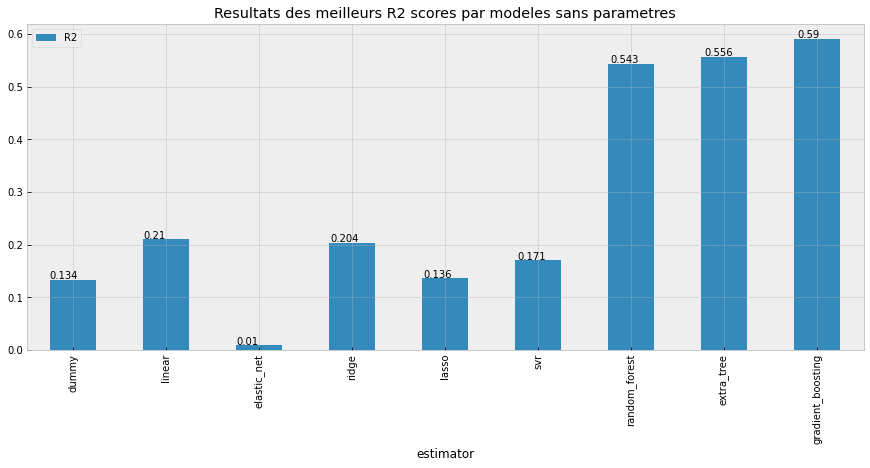

In [69]:
algo_estimatorDefaults.getBestModeleScore_graphR2()

In [70]:
algo_estimatorDefaults.getBestModeleScore_summary(showR2=True)

R2          MAE         RMSE
estimator                                         
dummy              0.134  2349435.923  3525321.572
linear             0.210  1678749.177  3681825.957
elastic_net        0.010  2205710.719  3326472.027
ridge              0.204  1675745.655  3672900.601
lasso              0.136  2356532.985  3527925.736
svr                0.171  2350047.618  3581969.243
random_forest      0.543  1404088.213  2231465.417
extra_tree         0.556  1394720.289  2202944.706
gradient_boosting  0.590  1338020.584  2116775.465

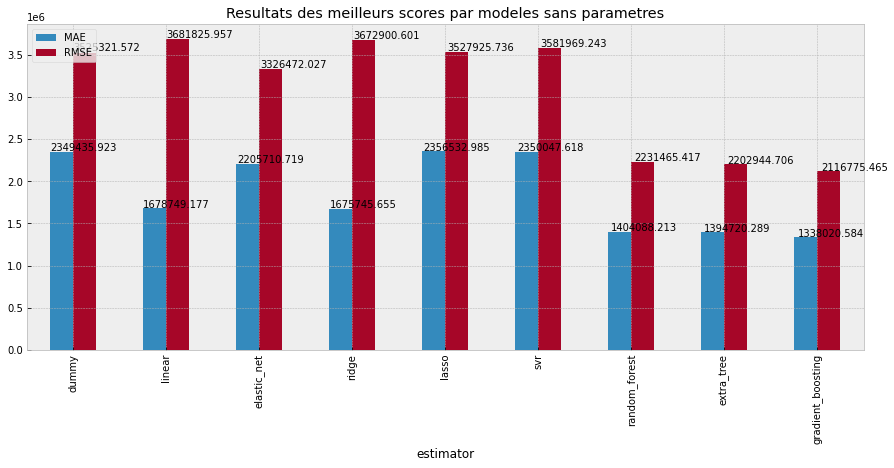

In [71]:
algo_estimatorDefaults.getBestModeleScore_graph()

## resultat des meilleurs scores par predictions

In [72]:
algo_estimatorDefaults.getBestModeleScore_scorePrediction(showR2=True)

R2          MAE          RMSE
estimator                                             
dummy              -0.10038  2158287.124  3.252122e+06
linear            -46.34157  3053103.836  2.133123e+07
elastic_net         0.03824  2023410.879  3.040383e+06
ridge             -53.43271  3147662.222  2.287308e+07
lasso              -0.10108  2159543.571  3.253143e+06
svr                -0.13525  2149638.769  3.303240e+06
random_forest       0.65644  1173501.448  1.817162e+06
extra_tree          0.65128  1201450.602  1.830775e+06
gradient_boosting   0.66803  1151245.250  1.786256e+06

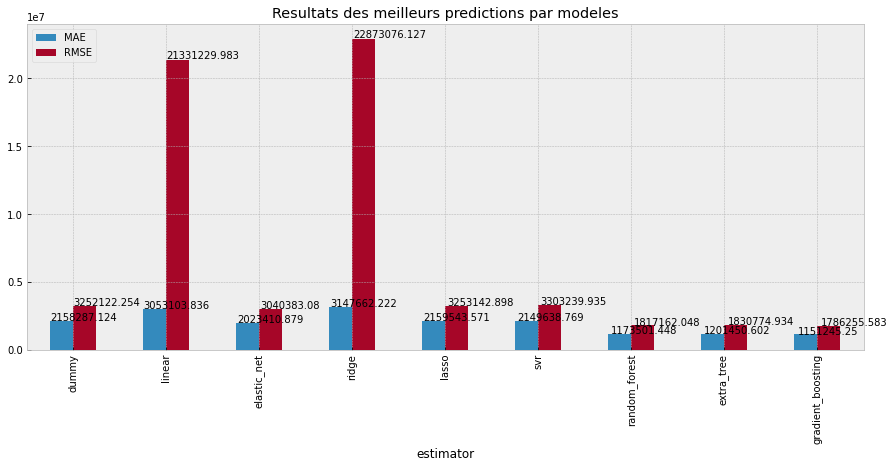

In [73]:
algo_estimatorDefaults.getBestModeleScore_graphpredictions()

**Par default les modeles ensemblistes gradient boosting , extra tree et random forest on les meilleurs resultats**


<a name='op'></a>
# Optimisation des resultats

Nous allons donc faire la meme chose avec en plus des plages d hyperparametres a tester pour chaque modeles

In [74]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import RidgeCV
from sklearn import linear_model

class EstimatorSelectionByAlgo:

    
    def __init__(self, models, params,useLog=True):
        self.models = models
        self.keys = models.keys()
        self.params = params
        self.grid_searches = {}
        self.useLog = useLog
        self.bestParams = {}
        self.scorer = {}
        self.cv_results = {}
        self.scoring = {
                        "r2" : "r2",
                        "mse" : "neg_mean_squared_error", 
                        "mae" : "neg_mean_absolute_error"
                    }
#         self.kfold = KFold(n_splits=5, random_state=0) 
        self.kfold = KFold(n_splits=5) 
#         self.kfold = StratifiedKFold(n_splits=5)
       
    
    def fit(self, X, y):
        starttotaltime = timeit.default_timer()
        for model_name in self.keys:
            print('Running GridSearchCV for %s.' % model_name)     
            starttime = timeit.default_timer()
            model = self.models[model_name]
            params = self.params[model_name]
            print('training model',model)
            if(self.useLog):
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=model, func=np.log1p,inverse_func=np.expm1)), 
                ])
            else:
                pipeline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,model) 
                        ])                      
            #GridSearchCV
            #RandomizedSearchCV
            grid_search = GridSearchCV(
                                    pipeline, 
                                    params,
                                    scoring = self.scoring,
                                    return_train_score = True,
                                    refit='mse',
                                    cv = self.kfold,
                                    n_jobs=-1
                                    )
#             print(grid_search.get_params().keys())
            grid_search.fit(X, y)
            self.bestParams[model_name] = grid_search.best_params_
            self.scorer[model_name] = grid_search.best_estimator_
            self.grid_searches[model_name] = grid_search
            self.cv_results[model_name] = grid_search.cv_results_
            
            
            elapsed = timeit.default_timer() - starttime
            print('training {} model done'.format(model_name))
            print("elapsed time {:.2f}s".format(elapsed))
        print('All training done.')
        elapsed = timeit.default_timer() - starttotaltime
        print("total time {:.2f}s".format(elapsed))
        
        
    def getBestParams(self):
        return self.bestParams
    
    def showBestParams(self,useindex=False):
        frames =[]
        result = pd.DataFrame()
        for name, bestParams in self.bestParams.items():      
            frame = pd.DataFrame()
            frame['estimator'] = [name]  
            frame['best_params'] = [bestParams]
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useindex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result     
    
    def getGetScorer(self):
        return self.scorer 
    
    def getCvResults(self):
        return sel.cv_results_
    

    
    def getScore_summary(self, sort_by='rank_test_mse'):
        frames = []
        for name, grid_search in self.grid_searches.items():            
            frame = pd.DataFrame(grid_search.cv_results_)
            
            #recuperation du meilleur modele
            #utiliser best_estimator egalement
#             best_model_index = grid_search.best_index_
#             score = [(grid_search.cv_results_["split" + str(i) + "_test_MSE"][best_model_index]) for i in range(5)]
#             print(score)            
#             mean_score, std_score = np.mean(score), np.std(score)                                    
#             # Making the prediction using the testing data
#             y_pred = grid_search.predict(X_test)  
#             frame['rmse_mean'] = mean_score
#             frame['variance'] = std_score
#             frame['score_train'] = -grid_search.score(X_train,y_train)
#             frame['score_test'] = -grid_search.score(X_test, y_test)        
#             frame['rmse'] = np.sqrt(mean_squared_error(y_test,y_pred))
#             frame['mae'] = mean_absolute_error(y_test,y_pred)            
#             frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = len(frame)*[name]
#             frame = frame[['rank_test_MSE','estimator','rmse','mae','mean_fit_time','rmse_mean','variance']]
            frames.append(frame)
        df = pd.concat(frames)        
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.sort_values([sort_by], ascending=True)
        df = df.drop([ 'index'], 1)
        return df    
    
     #retourne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summary(self,useIndex=False,showR2=False):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            #frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = [name]
            if(showR2):
              frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            frame["MAE"] = round(abs(results.iloc[grid_search.best_index_]["mean_test_mae"]), 3)
            frame["RMSE"] = round(math.sqrt(abs(results.iloc[grid_search.best_index_]["mean_test_mse"])), 3)
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        if(useIndex):
            df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df  

    #selectionne les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_summaryR2(self):
        frames=[]
        for name, grid_search in self.grid_searches.items():      
            results = pd.DataFrame(grid_search.cv_results_)
            frame = pd.DataFrame()
            frame['estimator'] = [name]
            frame["R2"] = ( round(abs(results.iloc[grid_search.best_index_]["mean_test_r2"]), 3))
            # frame['duration'] = round(results.iloc[grid_search.best_index_]["mean_score_time"], 3)      
            frames.append(frame)
        df = pd.concat(frames) 
        df = df.reset_index()
        df.set_index('estimator', inplace=True)
        df = df.drop([ 'index'], 1)
        return df 

    #affiche les meilleurs resulats par modele contenu dans cv_results et recupere r2,mae et rmse
    def getBestModeleScore_graphR2(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summaryR2().plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs R2 scores par modeles avec parametres ')
        plt.show()          

    def getBestModeleScore_graph(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_summary(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs scores par modeles apres hyperparametrisations')
        plt.show()  
    
     #renvoie les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_scorePrediction(self,useIndex=False, showR2=False):
        frames =[]
        result = pd.DataFrame()
        for name, grid_search in self.grid_searches.items():      
            frame = pd.DataFrame()
            #grid_search.predict(X_test) is equivalent to grid_search.best_estimator_.predict(X_test)
            y_pred = grid_search.predict(X_test) 
            frame['estimator'] = [name]  
            if(showR2):
              frame['R2'] = round((r2_score(y_test, y_pred)), 5)
            frame['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
            frame['RMSE'] = round(mean_squared_error(y_test, y_pred, squared=False), 3)
            
#             errors = abs(y_pred - y_test)
#             mape = 100 * np.mean(errors / y_test)
#             frame['accurracy'] = round(100 - mape, 4)            
            
            
            frames.append(frame)
        result = pd.concat(frames) 
        result = result.reset_index()
        if(useIndex):
            result.set_index('estimator', inplace=True)
        result = result.drop([ 'index'], 1)
        return result  
    
    #affiche les meilleurs resulats par modele contenu tester sur les variables test
    def getBestModeleScore_graphpredictions(self):          
        plt.rcParams['font.size'] = '10'
        ax = self.getBestModeleScore_scorePrediction(True).plot(kind='bar',figsize=(15,6)) 
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        plt.legend(loc=2)
        plt.title('Resultats des meilleurs predictions par modeles apres hyperparametrisations')
        plt.show()      
    

      
      
    #fonction qui creer une nouvelle validation curve le test sur le meilleurs modeles pour chaque
    #hyperparametres
    def showValidationCurvebyName(self,model_name,X_train,y_train): 
        gridsearch = self.grid_searches[model_name]
        params = self.params[model_name]
        fig, axes = plt.subplots(1, len(params), figsize = (6*len(params), 5),sharey='row')
        axes[0].set_ylabel("Score", fontsize=25)
        plt.suptitle("Validation Curve for model :{}".format(model_name), size=15)
        for idx, (param_name, param_range) in enumerate(sorted(params.items())):
            train_scores, test_scores = validation_curve(
                                            estimator=gridsearch.best_estimator_,
                                            X=X_train,
                                            y=y_train,
                                            cv=self.kfold,
                                            param_name=param_name,
                                            param_range=param_range
            )

            train_mean = np.mean(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)

            axes[idx].plot(param_range, train_mean,
                     marker='o', markersize=5,
                     color='r', label='Training Accuracy')
            axes[idx].plot(param_range, test_mean,
                     marker='o', markersize=5,
                     color='g', label='Validation Accuracy')
            axes[idx].set_title(param_name,fontsize = 14)
            
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)
        fig.subplots_adjust(bottom=0.25, top=0.85)  
        plt.show()         
                      
    #fonction qui test les resultats de la validation curve a partir des resultats gridsearch cv_results_
    def showValidationCurveInGCCVResultsByMetric(self,model_name,metric):
        #metric r2 mae ou mse
        ## Results from grid search
        grid = self.grid_searches[model_name]
        results = grid.cv_results_
        means_test = results['mean_test_'+metric]
        stds_test = results['std_test_'+metric]
        means_train = results['mean_train_'+metric]
        stds_train = results['std_train_'+metric]
        ## Getting indexes of values per hyper-parameter
        masks=[]
        masks_names= list(grid.best_params_.keys())
        for p_k, p_v in grid.best_params_.items():
            masks.append(list(results['param_'+p_k].data==p_v))
        params=grid.param_grid
        ## Ploting results
        fig, ax = plt.subplots(1, len(params), figsize = (6*len(params), 5),sharey='row')
        ax[0].set_ylabel("Score")
        plt.suptitle("Validation Curve in cv_results for {} metric:{}".format(model_name,metric), size=15)        
        pram_preformace_in_best = {}
        for i, p in enumerate(sorted(masks_names)):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test',color='g')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' ,color='r')
            ax[i].set_xlabel(p.upper())   
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)
        fig.subplots_adjust(bottom=0.25, top=0.85)  
        plt.show()  

#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.
    def getLearningCurveByName(self,model_name,X_train,y_train):
        ## Results from grid search
        grid = self.grid_searches[model_name]
        title = "learning curve for model {}".format(model_name)
        estimator = grid.best_estimator_
        # plot_learning_curve(
        #     estimator, title, X_train, y_train, ylim=(0.1, 1.01), cv=self.kfold, n_jobs=4
        # )
        estimator = grid.best_estimator_
        plot_learning_curve(
            estimator, title, X_train, y_train,ylim=None, cv=self.kfold, n_jobs=4
        )        
        plt.show()    
        
    #Show validation between real values vs predicted values        
    def showPredictionbyName(self,name,target,X_train,y_train):
        plot_cross_val_predi(self.grid_searches[name].best_estimator_, name, target, X_train, y_train, cv=self.kfold)

    #Show features importances for a model
    def showFeaturesImportancesbyName(self, name_model, X_train, y_train, scoring=None):
        results = permutation_importance(self.grid_searches[name_model].best_estimator_, X_train, y_train, scoring=scoring)
        importance = pd.DataFrame({
                            "feature" : X_train.columns,
                            "importance" : results.importances_mean
                        })

        importance = importance.sort_values("importance")   
        fig = plt.subplots(figsize=(8, 6))
        plot = sns.barplot(data=importance, y=importance["feature"], x=importance["importance"])
        plt.title(  "Features Importance for model "+name_model, fontdict={ "fontsize": 16, "fontweight": "normal" })
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()  
        
    #Show ridge or lasso coefficent alpha   
    def showRidgeOrLassoCoef(self,model_name):                
        fig = plt.figure(figsize=(15, 10))
        alphas = self.params[model_name][model_name+'__regressor__alpha']
        
        baseline =  Pipeline([
                ('preprocessor', preprocessor),
                (model_name,TransformedTargetRegressor(regressor=linear_model.LinearRegression(), func=np.log,inverse_func=np.exp)), 
                ])
        baseline.fit(X_train,y_train) 
        baseline_error = np.mean((baseline.predict(X_test) - y_test) ** 2)

        coefs = list()
        errors = list()
        for a in alphas:
            model = self.models[model_name]
            model.alpha = a
            model.fit_intercept = False
            pipeline =  Pipeline([
                            ('preprocessor', preprocessor),
                            (model_name,TransformedTargetRegressor(regressor=model, func=np.log,inverse_func=np.exp)), 
                            ])
            pipeline.fit(X_train,y_train) 
            coefs.append(pipeline[model_name].regressor_.coef_)
            errors.append([baseline_error, np.mean((pipeline.predict(X_test) - y_test) ** 2)])
        coefs = np.array(coefs)
        errors = np.array(errors)
        
        ax = plt.gca()
        ax.plot(alphas, coefs)
        ax.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('weights')
        plt.title('{} coefficients as function of the regularization'.format(model_name))
        plt.axis('tight')
        plt.legend(X_train.keys()) 
        plt.show()

        ax2 = plt.gca()
        ax2.plot(alphas, errors)
        ax2.set_xscale('log')
        plt.xlabel('alpha')
        plt.ylabel('error')
        plt.axis('tight')
        plt.title('valeur de l erreur quadratique')
        plt.show()
        
        #      display all the results for a model   
    def getAllResultsByModelName(self,model_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True,):
        t ,u ,p= self.getBestModeleScore_summary(showR2=True),self.getBestModeleScore_scorePrediction(showR2=True),self.showBestParams(False)
        # print('best parameter for {}'.format(modele_name))

        display(HTML('<h1>best parameter for {}'.format(modele_name)+'</h1>'))
        display(p[p['estimator']==modele_name])
        display(HTML('<h1>best model score {}'.format(modele_name)+'</h1>'))
        display(t[t['estimator']==modele_name])
        display(HTML('<h1>best model score prediction for {}'.format(modele_name)+'</h1>'))
        display(u[u['estimator']==modele_name])
        if(showLasso):
            display(HTML('<h1 style="text-align: center;">coefficients {}'.format(modele_name)+'</h1>'))
            self.showRidgeOrLassoCoef(modele_name)
        if(showLearningCure):
            display(HTML('<h1 style="text-align: center;">learning curve for {}'.format(modele_name)+'</h1>'))
            self.getLearningCurveByName(modele_name,X_train,y_train)   
        if(showValidationCurve):
            display(HTML('<h1 style="text-align: center;">validation curve from cv_results for {}'.format(modele_name)+'</h1>'))
            self.showValidationCurveInGCCVResultsByMetric(modele_name,'r2')  
        display(HTML('<h1 style="text-align: center;">prediction performance for {}'.format(modele_name)+'</h1>'))            
        self.showPredictionbyName(modele_name,target_variable,X_train,y_train)  
        if(showFeaturesImportances):
            display(HTML('<h1 style="text-align: center;">features importances for {}'.format(modele_name)+'</h1>'))
            self.showFeaturesImportancesbyName(modele_name, X_train, y_train, scoring='r2')
        
       


    
models = {   
    'dummy': DummyRegressor(),
    'linear':LinearRegression(),
    'elastic_net' : ElasticNet(),    
    'ridge':Ridge(),    
    'lasso':Lasso(),   
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'extra_tree': ExtraTreesRegressor(),
    'gradient_boosting' : GradientBoostingRegressor(),
}

params_models = {    
                    'dummy': {
                        'dummy__regressor__strategy':['mean', 'median', 'quantile', 'constant'],        
                    },
                    'linear':{
                        'linear__regressor__copy_X' : [True, False],
                        'linear__regressor__fit_intercept' : [True, False] 
                        },    
                    'elastic_net': {                
                        'elastic_net__regressor__max_iter': [1500,2000,3000],
                        'elastic_net__regressor__alpha': np.arange(0.1, 1, .2).tolist(),        
                        'elastic_net__regressor__selection' :['cyclic', 'random'],
                        'elastic_net__regressor__l1_ratio': np.arange(0.0, 1.0, 0.4)
                    },

                    'ridge':{
                        'ridge__regressor__alpha': np.logspace(-5, 5, 100),
                        'ridge__regressor__max_iter': [1000,2000],        
                    },

                    'lasso':{
                        'lasso__regressor__alpha': np.logspace(-5, 5, 100),
                        'lasso__regressor__max_iter': [1000,2000],        
                    },

                    'svr': {                
                        'svr__regressor__C': [0.5,1,2,3],
                        'svr__regressor__kernel': ['linear', 'sigmoid', 'rbf'],
                        'svr__regressor__gamma': ["auto", "scale"],

                        # 'svr__regressor__gamma': np.arange(0.01, 1, 0.1).tolist(),
                        'svr__regressor__epsilon':  [0.1, 0.2, 0.3, 0.4,0.5]
                        
                            },
                    'random_forest': {        
                            # 'random_forest__regressor__n_estimators': [ 50, 80, 100, 120, 140] ,
                            'random_forest__regressor__n_estimators': [ 80, 100, 140, 200,500] ,
                            'random_forest__regressor__max_features': ['auto', 'sqrt'],               
                            },
                    'extra_tree': {                
                            # 'extra_tree__regressor__n_estimators': [ 50, 80, 100, 120, 140],  
                            'extra_tree__regressor__n_estimators': [80, 100, 140, 200],  
                            'extra_tree__regressor__bootstrap': [ True,False],                     
                            'extra_tree__regressor__min_samples_split':  np.arange(2,6,2),         
                        
                    },
                    'gradient_boosting' :{                        
                        "gradient_boosting__regressor__n_estimators":[100, 200, 500,1000],
                        "gradient_boosting__regressor__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
                        "gradient_boosting__regressor__learning_rate": np.arange(0.01,1,0.2)
                    }
}     

algo_estimator = EstimatorSelectionByAlgo(models, params_models,True)
algo_estimator.fit(X_train,y_train)

Running GridSearchCV for dummy.
training model DummyRegressor()
training dummy model done
elapsed time 0.52s
Running GridSearchCV for linear.
training model LinearRegression()
training linear model done
elapsed time 0.59s
Running GridSearchCV for elastic_net.
training model ElasticNet()
training elastic_net model done
elapsed time 8.09s
Running GridSearchCV for ridge.
training model Ridge()
training ridge model done
elapsed time 17.62s
Running GridSearchCV for lasso.
training model Lasso()
training lasso model done
elapsed time 17.14s
Running GridSearchCV for svr.
training model SVR()
training svr model done
elapsed time 13.17s
Running GridSearchCV for random_forest.
training model RandomForestRegressor()
training random_forest model done
elapsed time 4.03s
Running GridSearchCV for extra_tree.
training model ExtraTreesRegressor()
training extra_tree model done
elapsed time 3.02s
Running GridSearchCV for gradient_boosting.
training model GradientBoostingRegressor()
training gradient_boo

<a name='op2'></a>
## resultat des meilleurs scores par modeles apres optimisation

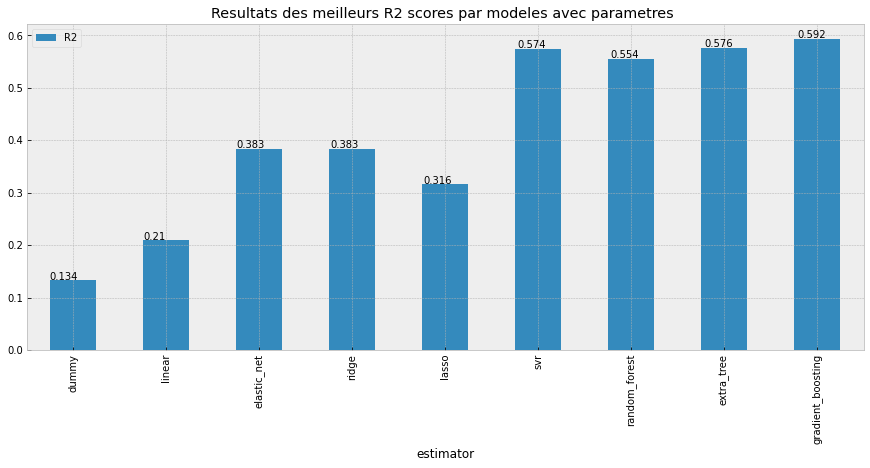

In [75]:
algo_estimator.getBestModeleScore_graphR2()

In [76]:
algo_estimator.getBestModeleScore_summary(useIndex=True,showR2=True)

R2          MAE         RMSE
estimator                                         
dummy              0.134  2349435.923  3525321.572
linear             0.210  1678749.177  3681825.957
elastic_net        0.383  1640605.340  2595151.540
ridge              0.383  1638133.206  2595409.799
lasso              0.316  1737910.221  2729449.726
svr                0.574  1360548.970  2160056.040
random_forest      0.554  1388641.470  2205731.693
extra_tree         0.576  1348088.242  2154301.285
gradient_boosting  0.592  1328329.803  2111314.945

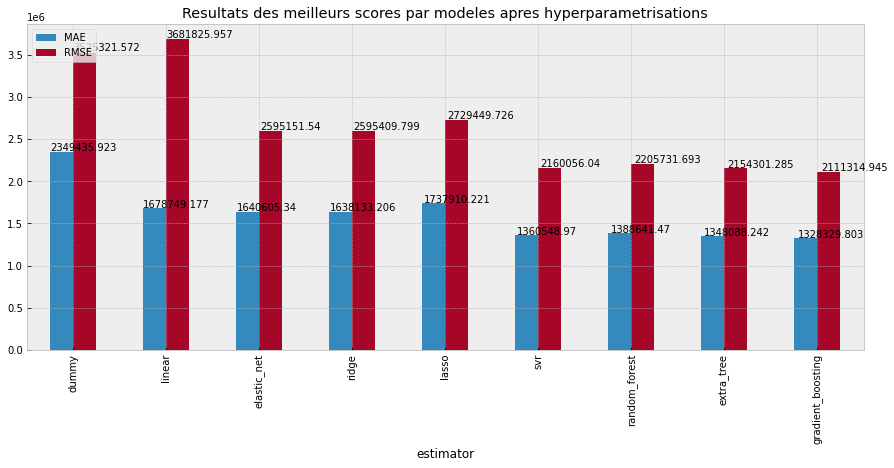

In [77]:
algo_estimator.getBestModeleScore_graph()

## resultat des meilleurs scores par predictions

Maintenand que notre entrainement est terminer , nous pouvons etudier nos resultats par modeles.

Recapitulons nous avons un ensemble de features que nous avons entrainer en fonction de notre variable cible a partir des metriques mae et rmse , l a metrique r2 est ici a titre indicatif

In [78]:
algo_estimator.getBestModeleScore_summary(useIndex=True,showR2=True).compare(algo_estimatorDefaults.getBestModeleScore_summary(showR2=True), align_axis=0).rename(index={'self': 'with options', 'other': 'default'})

R2          MAE         RMSE
estimator                                                      
elastic_net       with options  0.383  1640605.340  2595151.540
                  default       0.010  2205710.719  3326472.027
ridge             with options  0.383  1638133.206  2595409.799
                  default       0.204  1675745.655  3672900.601
lasso             with options  0.316  1737910.221  2729449.726
                  default       0.136  2356532.985  3527925.736
svr               with options  0.574  1360548.970  2160056.040
                  default       0.171  2350047.618  3581969.243
random_forest     with options  0.554  1388641.470  2205731.693
                  default       0.543  1404088.213  2231465.417
extra_tree        with options  0.576  1348088.242  2154301.285
                  default       0.556  1394720.289  2202944.706
gradient_boosting with options  0.592  1328329.803  2111314.945
                  default       0.590  1338020.584  2116775.465

In [79]:
withParam = algo_estimator.getBestModeleScore_scorePrediction(True, showR2=True)
withoutparam = algo_estimatorDefaults.getBestModeleScore_scorePrediction(True, showR2=True)

L ajout de nos hyperparametres a ameliorer nos resultats par rapport aux modeles par default

Le modele gradiant boosting a a peu pres les memes resultats avec ou sans hyperparametres

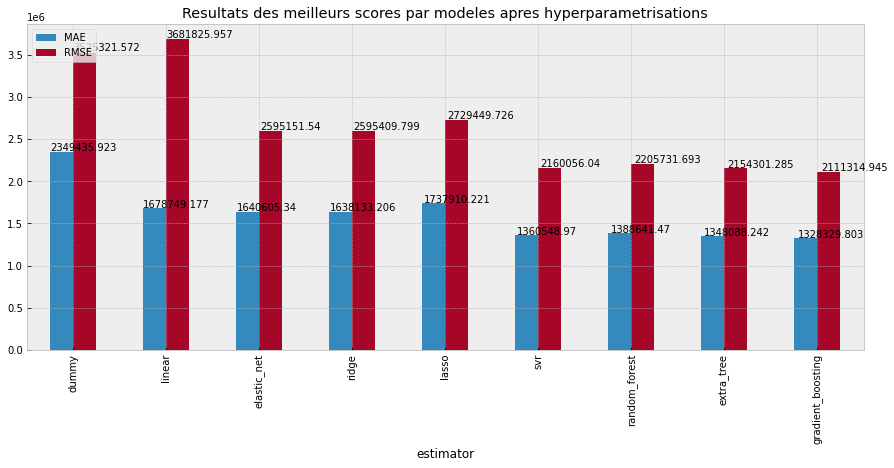

In [80]:
algo_estimator.getBestModeleScore_graph()

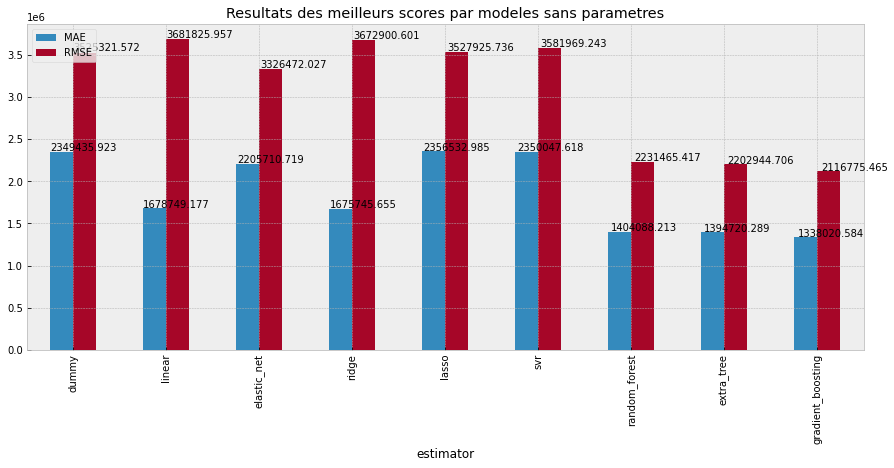

In [81]:
algo_estimatorDefaults.getBestModeleScore_graph()

<a name='cu'></a>
# comparaisons des predictions par defaults et custom

Maintenant comparons les scores des predictions par modeles avec ou sans hyper parametres

In [82]:
algo_estimator.getBestModeleScore_scorePrediction(useIndex=True, showR2=True).compare(algo_estimatorDefaults.getBestModeleScore_scorePrediction(True, showR2=True), align_axis=0).rename(index={'self': 'with options', 'other': 'default'})

R2          MAE          RMSE
estimator                                                          
elastic_net       with options  -0.41428  1786815.168  3.686906e+06
                  default        0.03824  2023410.879  3.040383e+06
ridge             with options  -0.87808  1830047.140  4.248659e+06
                  default      -53.43271  3147662.222  2.287308e+07
lasso             with options  -1.21317  1851654.659  4.612137e+06
                  default       -0.10108  2159543.571  3.253143e+06
svr               with options   0.62650  1239677.193  1.894686e+06
                  default       -0.13525  2149638.769  3.303240e+06
random_forest     with options   0.67616  1154977.467  1.764236e+06
                  default        0.65644  1173501.448  1.817162e+06
extra_tree        with options   0.67860  1143173.744  1.757592e+06
                  default        0.65128  1201450.602  1.830775e+06
gradient_boosting with options   0.66977  1142301.909  1.781560e+06
                  default        0.66803  1151245.250  1.786256e+06

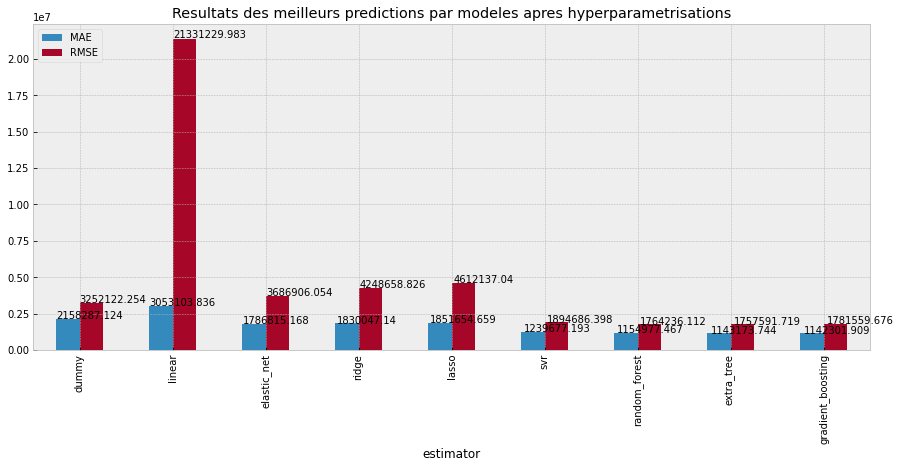

In [83]:
algo_estimator.getBestModeleScore_graphpredictions()

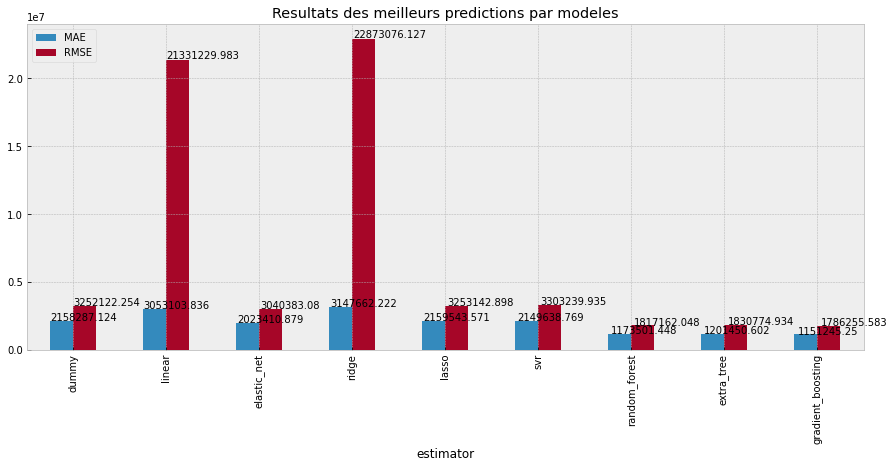

In [84]:
algo_estimatorDefaults.getBestModeleScore_graphpredictions()

Grace a nos hyperparametres nous avons ameliores globalement nos modeles

**Meilleurs parametres pour chaque modeles**

In [85]:
algo_estimator.showBestParams()

estimator  \
0              dummy   
1             linear   
2        elastic_net   
3              ridge   
4              lasso   
5                svr   
6      random_forest   
7         extra_tree   
8  gradient_boosting   

                                                                                                                                                                               best_params  
0                                                                                                                                                   {'dummy__regressor__strategy': 'mean'}  
1                                                                                                            {'linear__regressor__copy_X': True, 'linear__regressor__fit_intercept': True}  
2  {'elastic_net__regressor__alpha': 0.9000000000000001, 'elastic_net__regressor__l1_ratio': 0.0, 'elastic_net__regressor__max_iter': 1500, 'elastic_net__regressor__selection': 'random'}  
3                                                                                                        {'ridge__regressor__alpha': 756.463327554629, 'ridge__regressor__max_iter': 1000}  
4                                                                                                      {'lasso__regressor__alpha': 0.1747528400007683, 'lasso__regressor__max_iter': 1000}  
5                                                             {'svr__regressor__C': 0.5, 'svr__regressor__epsilon': 0.1, 'svr__regressor__gamma': 'auto', 'svr__regressor__kernel': 'rbf'}  
6                                                                                         {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 80}  
7                                                     {'extra_tree__regressor__bootstrap': True, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 80}  
8                           {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 100, 'gradient_boosting__regressor__n_estimators': 1000}

# optimisation de linear regression

In [86]:
sorted(algo_estimator.grid_searches['linear'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__linear',
 'estimator__linear__check_inverse',
 'estimator__linear__func',
 'estimator__linear__inverse_func',
 'estimator__linear__regressor',
 'estimator__linear__regressor__copy_X',
 'estimator__linear__regressor__fit_intercept',
 'estimator__linear__regressor__n_jobs',
 'estimator__linear__regressor__normalize',
 'estimator__linear__regressor__positive',
 'estimator__linear__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 

estimator  \
1    linear   

                                                                     best_params  
1  {'linear__regressor__copy_X': True, 'linear__regressor__fit_intercept': True}

estimator    R2          MAE         RMSE
1    linear  0.21  1678749.177  3681825.957

estimator        R2          MAE          RMSE
1    linear -46.34157  3053103.836  2.133123e+07

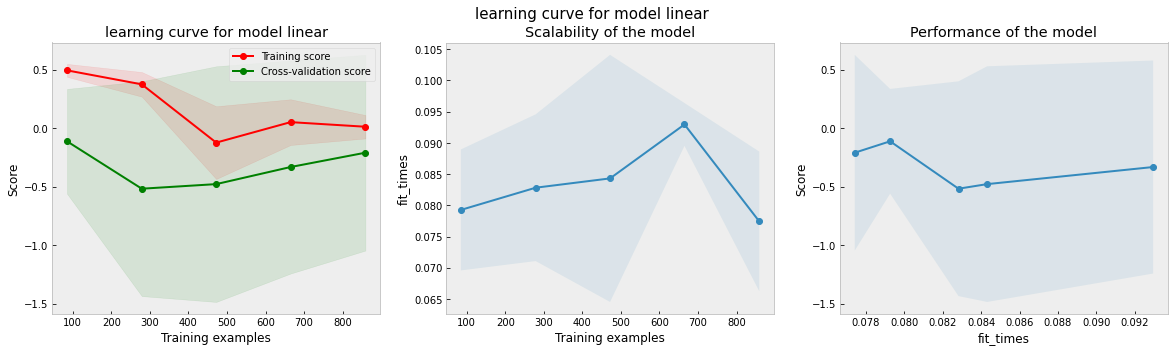

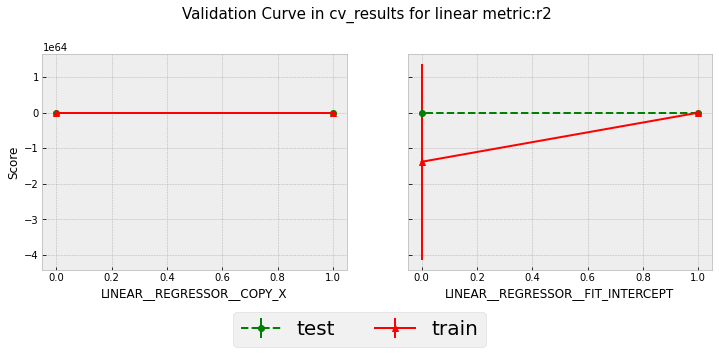

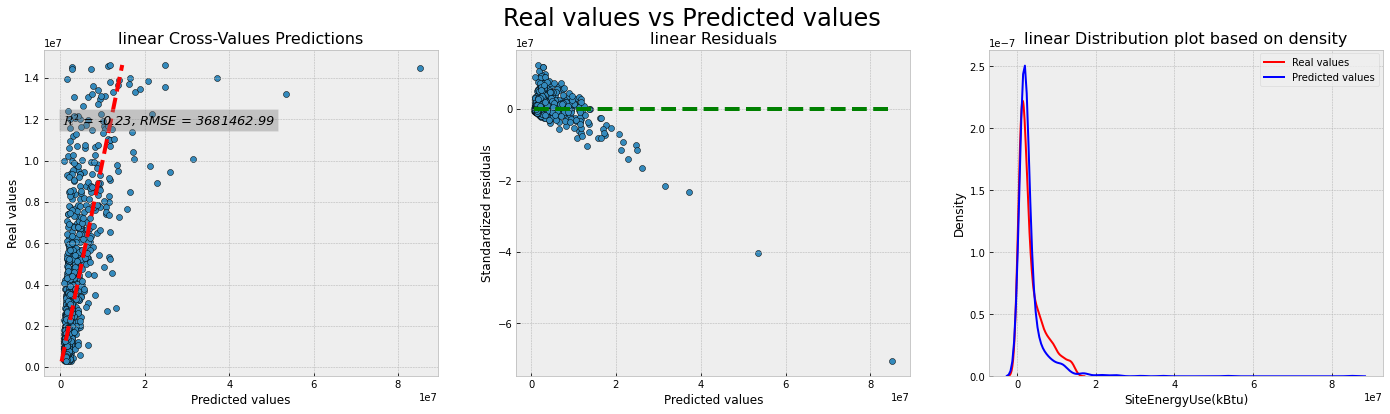

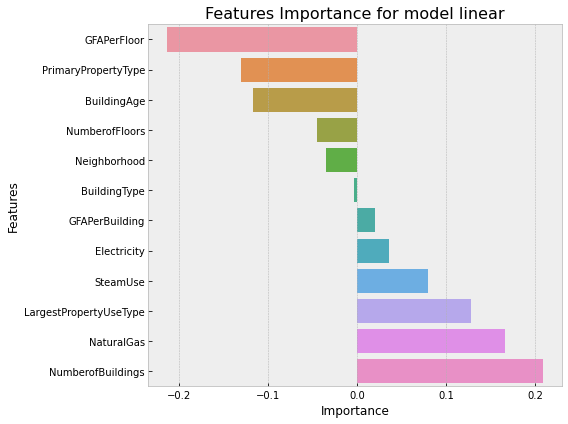

In [87]:
modele_name = 'linear'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [88]:
sorted(algo_estimator.grid_searches['dummy'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__dummy',
 'estimator__dummy__check_inverse',
 'estimator__dummy__func',
 'estimator__dummy__inverse_func',
 'estimator__dummy__regressor',
 'estimator__dummy__regressor__constant',
 'estimator__dummy__regressor__quantile',
 'estimator__dummy__regressor__strategy',
 'estimator__dummy__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__st

Le modele Dummy sera pris comme baseline de comparaisons

estimator                             best_params
0     dummy  {'dummy__regressor__strategy': 'mean'}

estimator     R2          MAE         RMSE
0     dummy  0.134  2349435.923  3525321.572

estimator       R2          MAE         RMSE
0     dummy -0.10038  2158287.124  3252122.254

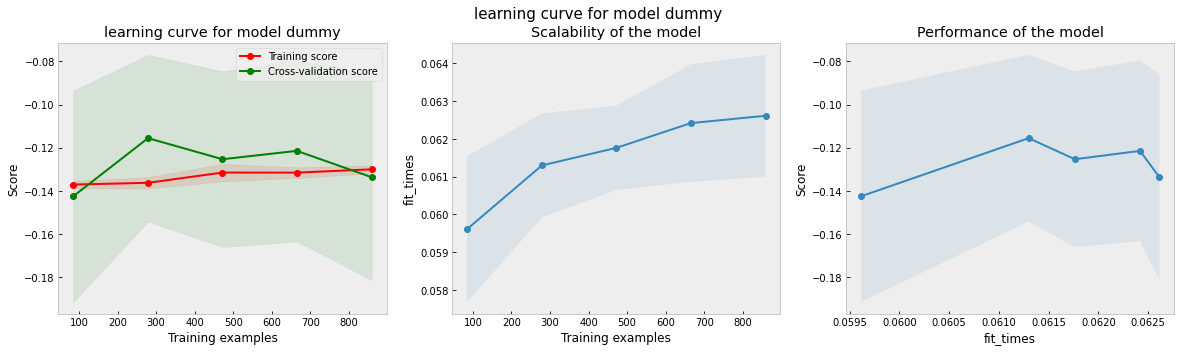

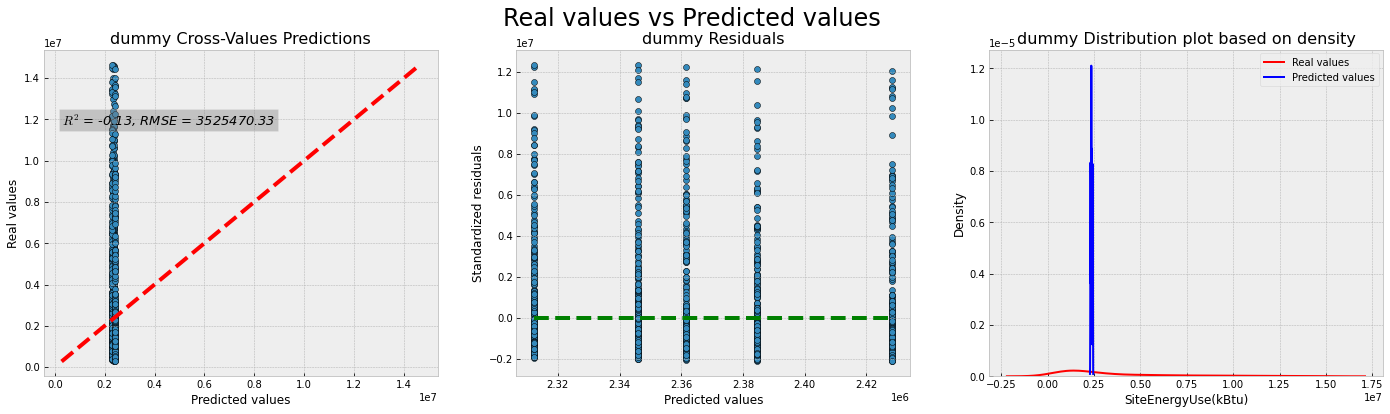

In [89]:
modele_name = 'dummy'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=False,showLasso=False,showFeaturesImportances=False)

In [90]:
sorted(algo_estimator.grid_searches['ridge'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

# Régularisation

La procédure de régularisation a pour but d'éviter que le modèle ne surapprenne (en anglais overfit) les données et ainsi vise à régler les problèmes de grande variance


le modele ridge rend les coefficients plus petits

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/ridge.png?77abafe4253433af93fb8ffc7d4f6bc7">

estimator  \
3     ridge   

                                                                         best_params  
3  {'ridge__regressor__alpha': 756.463327554629, 'ridge__regressor__max_iter': 1000}

estimator     R2          MAE         RMSE
3     ridge  0.383  1638133.206  2595409.799

estimator       R2         MAE         RMSE
3     ridge -0.87808  1830047.14  4248658.826

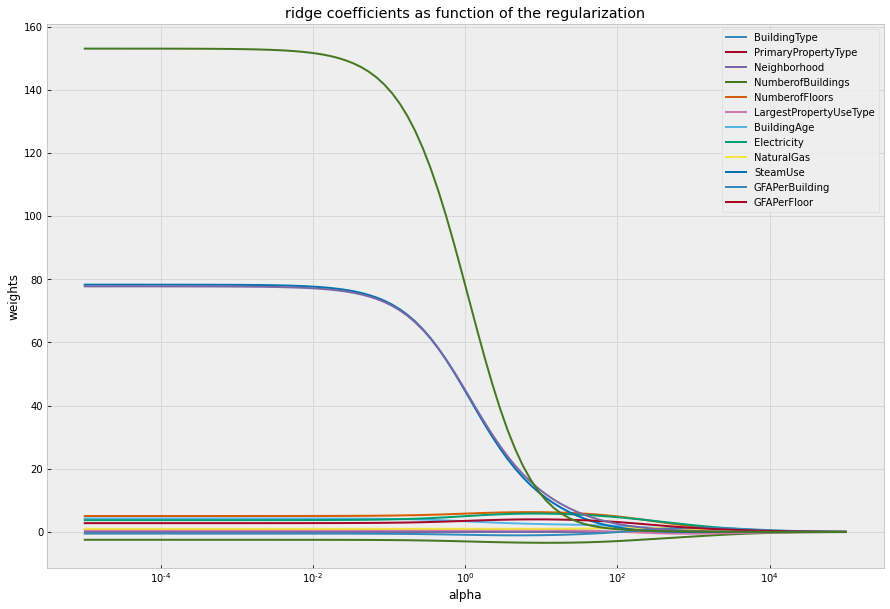

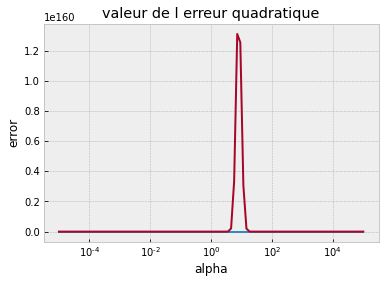

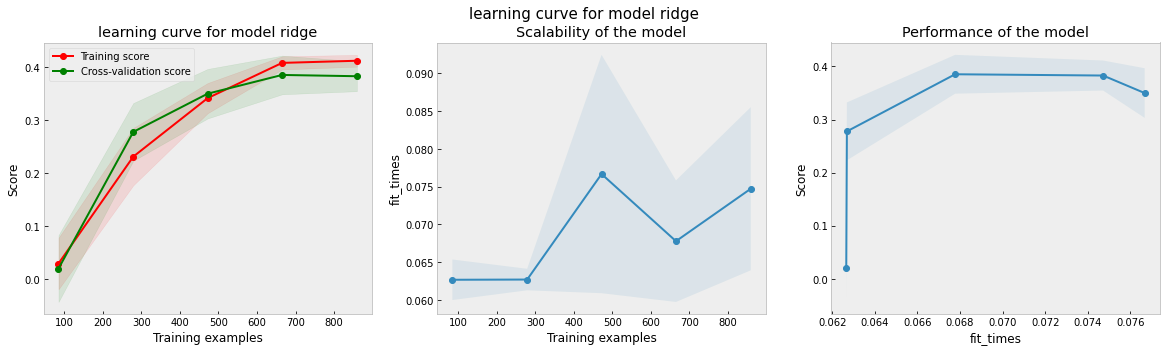

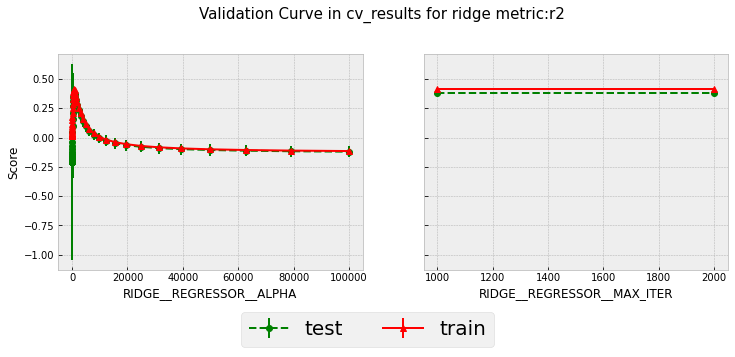

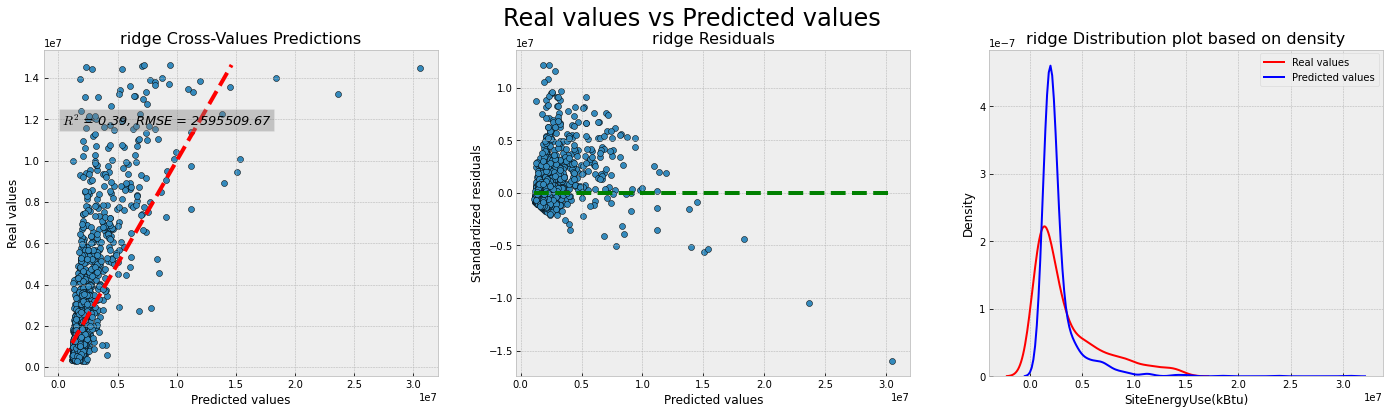

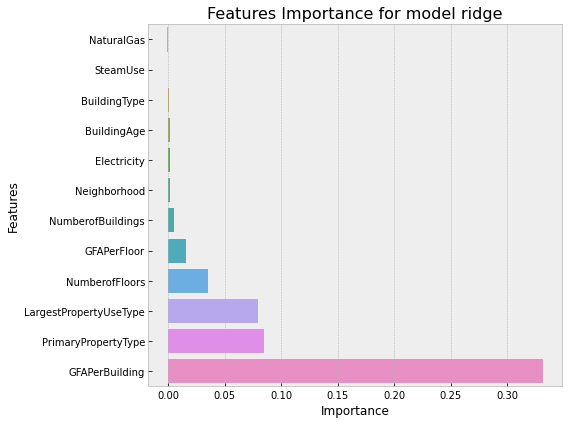

In [91]:
modele_name = 'ridge'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=True,showFeaturesImportances=True)

In [92]:
sorted(algo_estimator.grid_searches['lasso'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__lasso',
 'estimator__lasso__check_inverse',
 'estimator__lasso__func',
 'estimator__lasso__inverse_func',
 'estimator__lasso__regressor',
 'estimator__lasso__regressor__alpha',
 'estimator__lasso__regressor__copy_X',
 'estimator__lasso__regressor__fit_intercept',
 'estimator__lasso__regressor__max_iter',
 'estimator__lasso__regressor__normalize',
 'estimator__lasso__regressor__positive',
 'estimator__lasso__regressor__precompute',
 'estimator__lasso__regressor__random_state',
 'estimator__lasso__regressor__selection',
 'estimator__lasso__regressor__tol',
 'estimator__lasso__regressor__warm_start',
 'estimator__lasso__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',

le modele Lasso

• Réduit les coefficients à 0

• Bon pour la sélection de variables

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/lasso.png?ad67282f00fc8b2a529e5b15a856f91b">

estimator  \
4     lasso   

                                                                           best_params  
4  {'lasso__regressor__alpha': 0.1747528400007683, 'lasso__regressor__max_iter': 1000}

estimator     R2          MAE         RMSE
4     lasso  0.316  1737910.221  2729449.726

estimator       R2          MAE        RMSE
4     lasso -1.21317  1851654.659  4612137.04

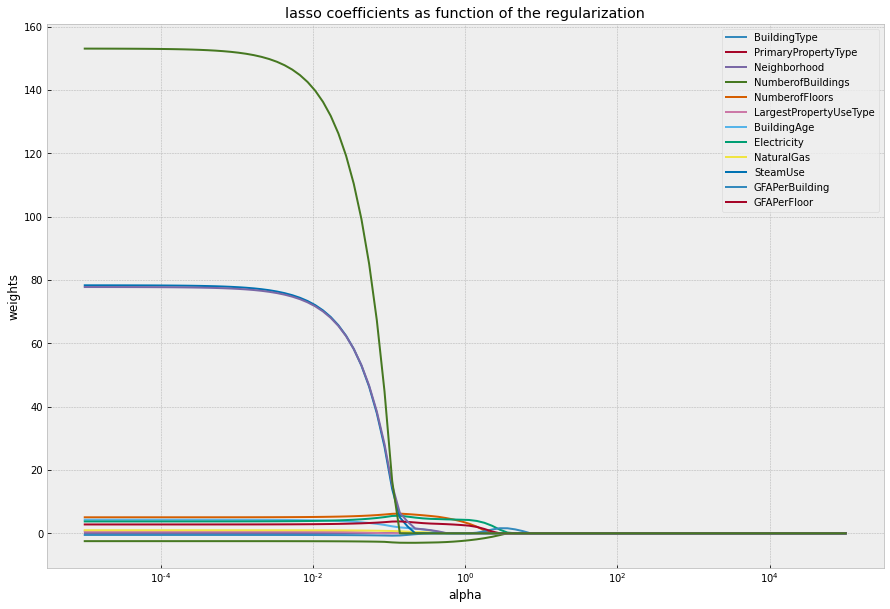

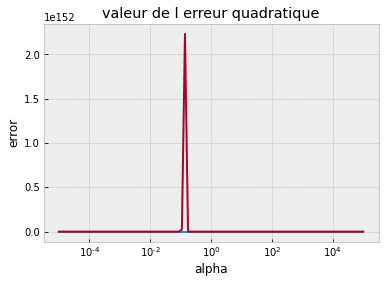

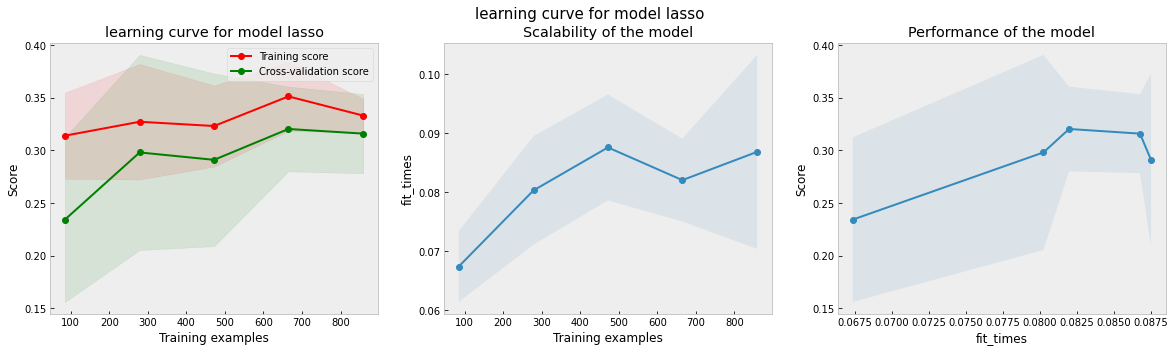

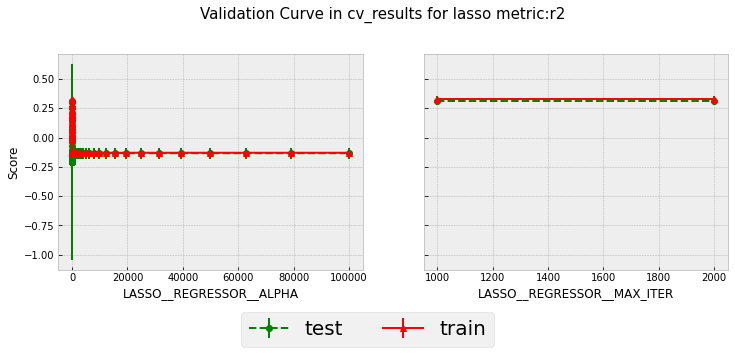

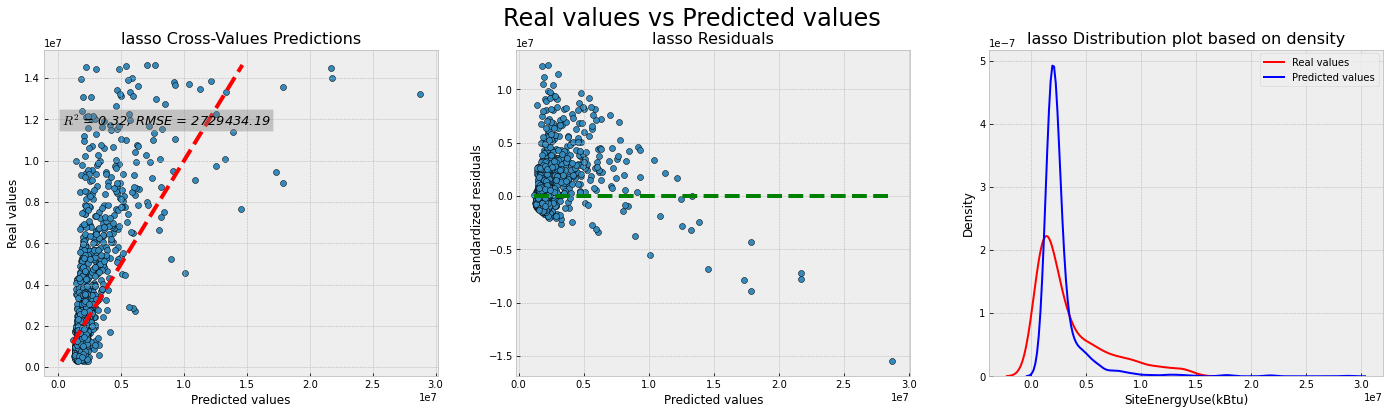

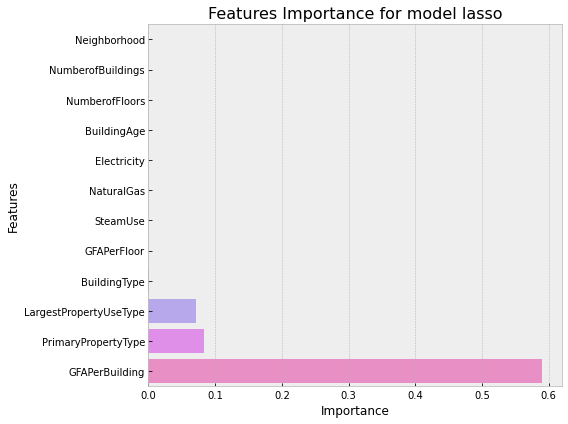

In [93]:
modele_name = 'lasso'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=True,showFeaturesImportances=True)

In [94]:
sorted(algo_estimator.grid_searches['elastic_net'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__elastic_net',
 'estimator__elastic_net__check_inverse',
 'estimator__elastic_net__func',
 'estimator__elastic_net__inverse_func',
 'estimator__elastic_net__regressor',
 'estimator__elastic_net__regressor__alpha',
 'estimator__elastic_net__regressor__copy_X',
 'estimator__elastic_net__regressor__fit_intercept',
 'estimator__elastic_net__regressor__l1_ratio',
 'estimator__elastic_net__regressor__max_iter',
 'estimator__elastic_net__regressor__normalize',
 'estimator__elastic_net__regressor__positive',
 'estimator__elastic_net__regressor__precompute',
 'estimator__elastic_net__regressor__random_state',
 'estimator__elastic_net__regressor__selection',
 'estimator__elastic_net__regressor__tol',
 'estimator__elastic_net__regressor__warm_start',
 'estimator__elastic_net__transformer',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__bo

le modele Lasso elastic_net fait un compromis entre la sélection de variables et la réduction de coefficients

<img alt="Ridge" width='200' height='200' class="img-responsive" src="https://stanford.edu/~shervine/teaching/cs-229/illustrations/elastic-net.png?8cd93eb9df1b6ae667d8eb69d20bf4a1">

estimator  \
2  elastic_net   

                                                                                                                                                                               best_params  
2  {'elastic_net__regressor__alpha': 0.9000000000000001, 'elastic_net__regressor__l1_ratio': 0.0, 'elastic_net__regressor__max_iter': 1500, 'elastic_net__regressor__selection': 'random'}

estimator     R2         MAE        RMSE
2  elastic_net  0.383  1640605.34  2595151.54

estimator       R2          MAE         RMSE
2  elastic_net -0.41428  1786815.168  3686906.054

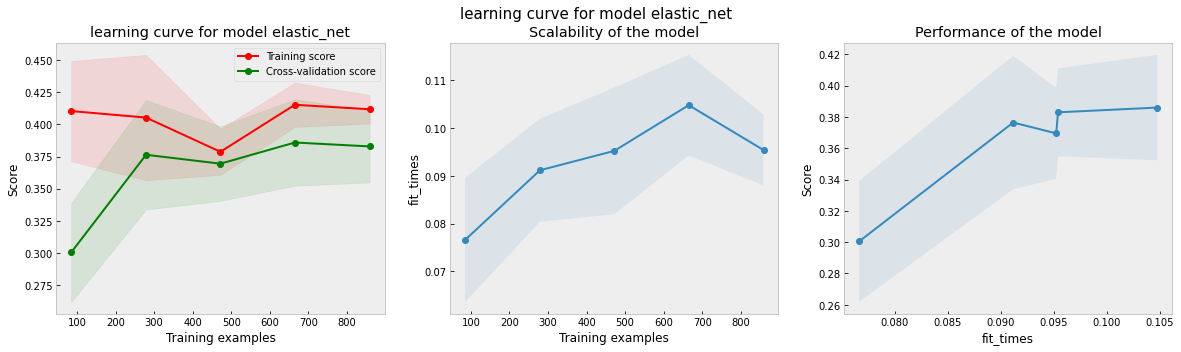

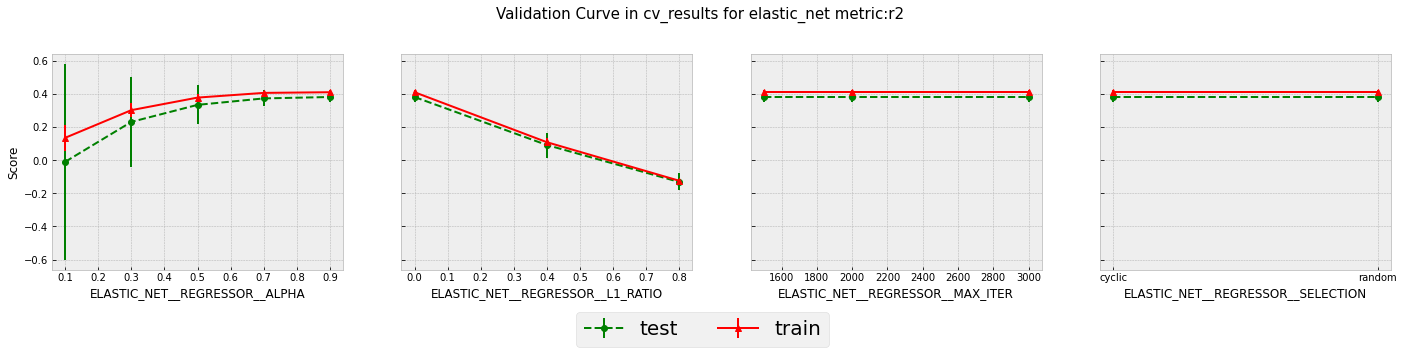

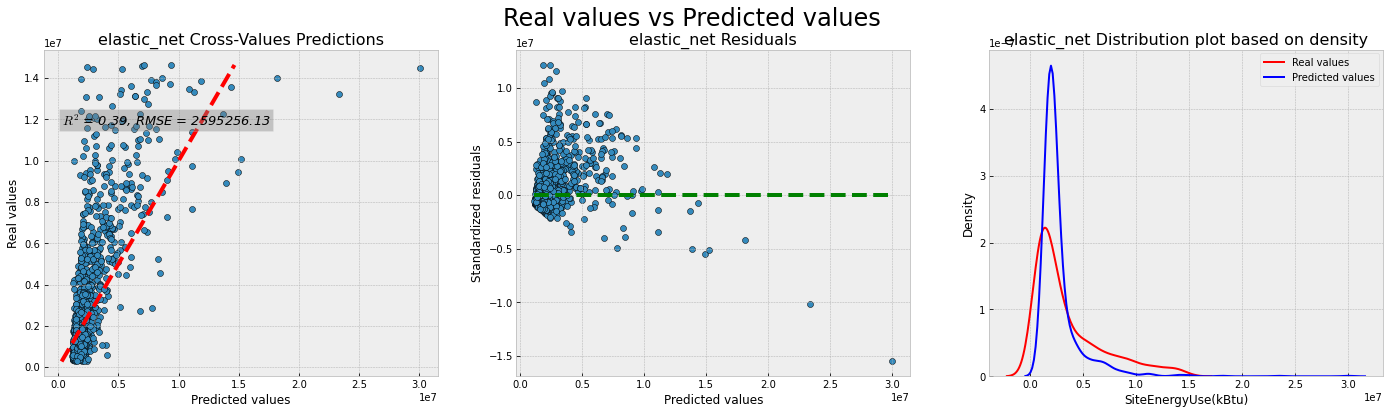

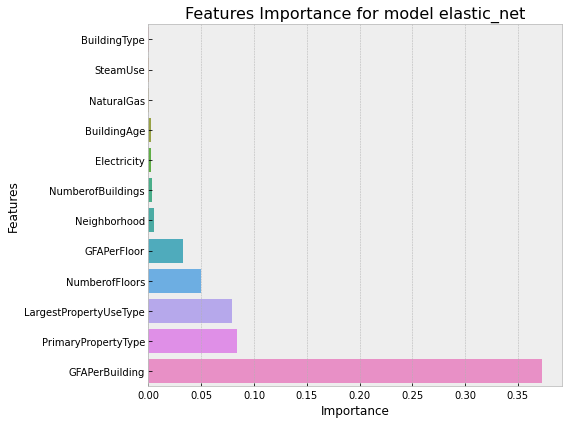

In [95]:
modele_name = 'elastic_net'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [96]:
sorted(algo_estimator.grid_searches['svr'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

Le SVR (Support Vector Regression) est une régression vectorielle de type Epsilon-support et est implémenté au niveau de libsvm.

estimator  \
5       svr   

                                                                                                                    best_params  
5  {'svr__regressor__C': 0.5, 'svr__regressor__epsilon': 0.1, 'svr__regressor__gamma': 'auto', 'svr__regressor__kernel': 'rbf'}

estimator     R2         MAE        RMSE
5       svr  0.574  1360548.97  2160056.04

estimator      R2          MAE         RMSE
5       svr  0.6265  1239677.193  1894686.398

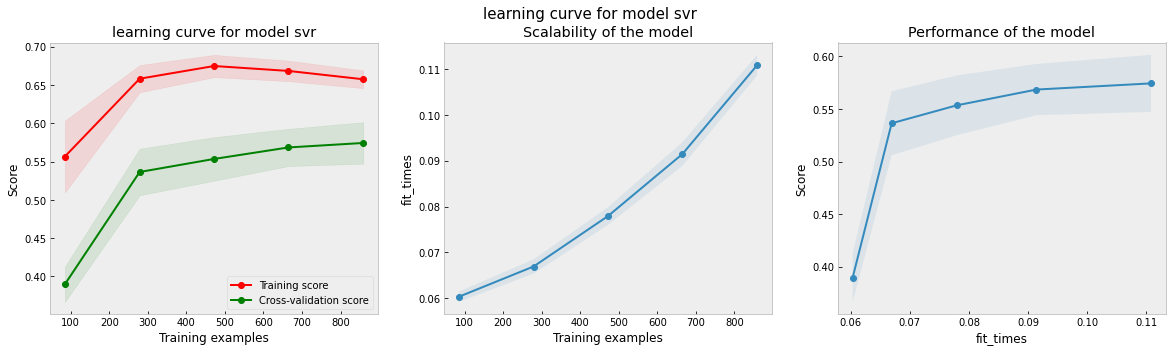

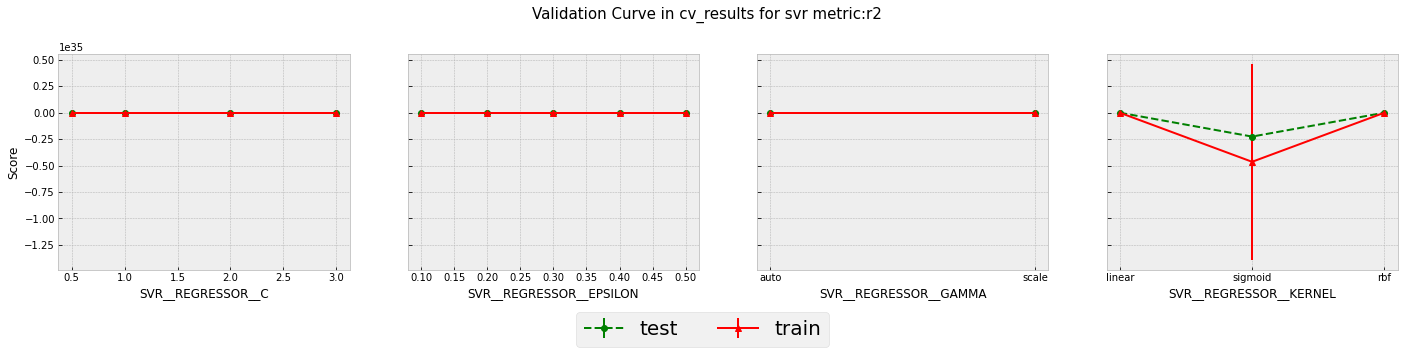

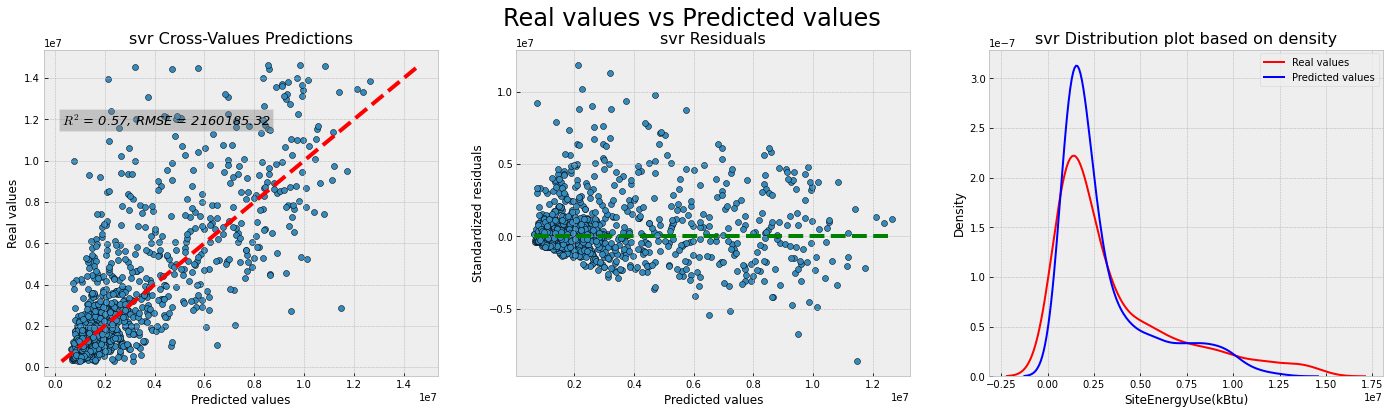

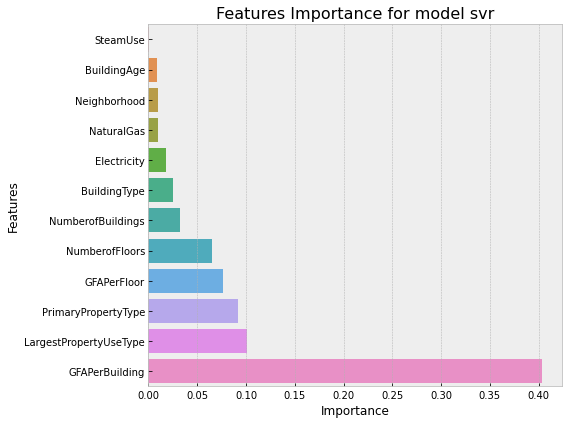

In [97]:
modele_name = 'svr'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

**Random Forest** : C'est une technique à base d'arbres qui utilise un très grand nombre d'arbres de décisions construits à partir d'ensembles de caractéristiques aléatoirement sélectionnés. Contrairement à un simple arbre de décision, il n'est pas interprétable du tout mais le fait qu'il ait une bonne performance en fait un algorithme populaire.

In [98]:
sorted(algo_estimator.grid_searches['random_forest'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__memory',
 'estimator__preprocessor',
 'estimator__preprocessor__boolean',
 'estimator__preprocessor__boolean__memory',
 'estimator__preprocessor__boolean__otherEnergy',
 'estimator__preprocessor__boolean__otherEnergy__accept_sparse',
 'estimator__preprocessor__boolean__otherEnergy__check_inverse',
 'estimator__preprocessor__boolean__otherEnergy__func',
 'estimator__preprocessor__boolean__otherEnergy__inv_kw_args',
 'estimator__preprocessor__boolean__otherEnergy__inverse_func',
 'estimator__preprocessor__boolean__otherEnergy__kw_args',
 'estimator__preprocessor__boolean__otherEnergy__validate',
 'estimator__preprocessor__boolean__steps',
 'estimator__preprocessor__boolean__verbose',
 'estimator__preprocessor__categorical',
 'estimator__preprocessor__categorical__memory',
 'estimator__preprocessor__categorical__rob_scaler',
 'estimator__preprocessor__categorical__rob_scaler__copy',
 'estimator__preprocessor__categorical__rob_scaler__quant

estimator  \
6  random_forest   

                                                                                        best_params  
6  {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 80}

estimator     R2         MAE         RMSE
6  random_forest  0.554  1388641.47  2205731.693

estimator       R2          MAE         RMSE
6  random_forest  0.67616  1154977.467  1764236.112

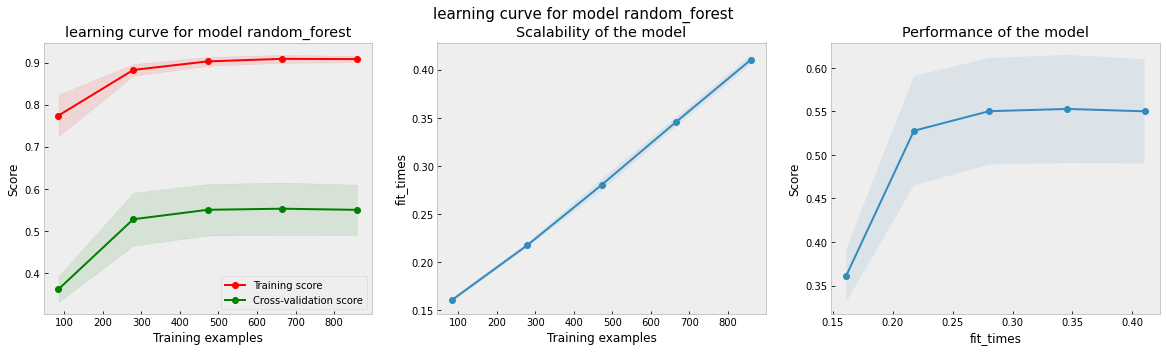

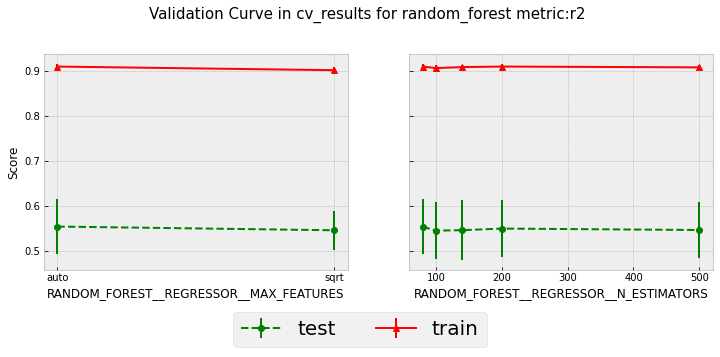

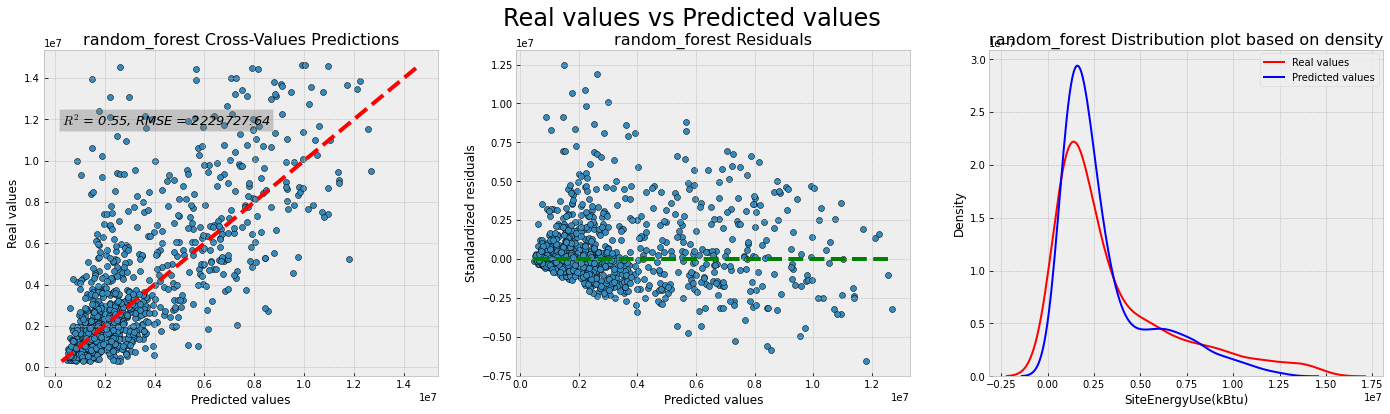

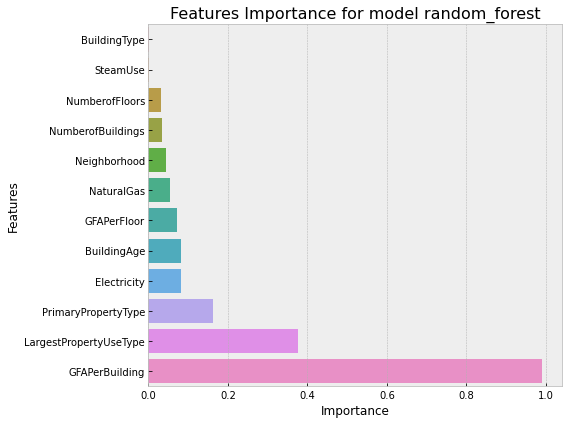

In [99]:
modele_name = 'random_forest'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [100]:
sorted(algo_estimator.grid_searches['extra_tree'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__extra_tree',
 'estimator__extra_tree__check_inverse',
 'estimator__extra_tree__func',
 'estimator__extra_tree__inverse_func',
 'estimator__extra_tree__regressor',
 'estimator__extra_tree__regressor__bootstrap',
 'estimator__extra_tree__regressor__ccp_alpha',
 'estimator__extra_tree__regressor__criterion',
 'estimator__extra_tree__regressor__max_depth',
 'estimator__extra_tree__regressor__max_features',
 'estimator__extra_tree__regressor__max_leaf_nodes',
 'estimator__extra_tree__regressor__max_samples',
 'estimator__extra_tree__regressor__min_impurity_decrease',
 'estimator__extra_tree__regressor__min_samples_leaf',
 'estimator__extra_tree__regressor__min_samples_split',
 'estimator__extra_tree__regressor__min_weight_fraction_leaf',
 'estimator__extra_tree__regressor__n_estimators',
 'estimator__extra_tree__regressor__n_jobs',
 'estimator__extra_tree__regressor__oob_score',
 'estimator__extra_tree__regressor__random_state',
 'estimator_

Extra_tree implémente un méta-estimateur qui ajuste un certain nombre d'arbres de décision aléatoires (alias extra-arbres)sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement.

estimator  \
7  extra_tree   

                                                                                                                            best_params  
7  {'extra_tree__regressor__bootstrap': True, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 80}

estimator     R2          MAE         RMSE
7  extra_tree  0.576  1348088.242  2154301.285

estimator      R2          MAE         RMSE
7  extra_tree  0.6786  1143173.744  1757591.719

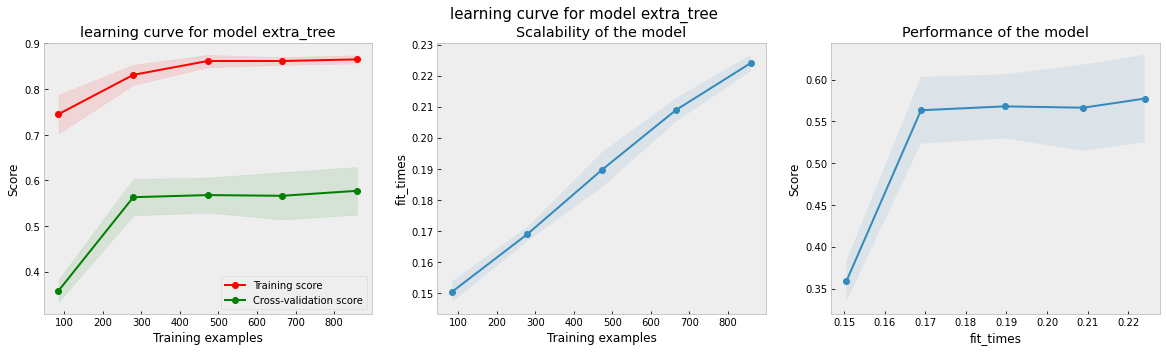

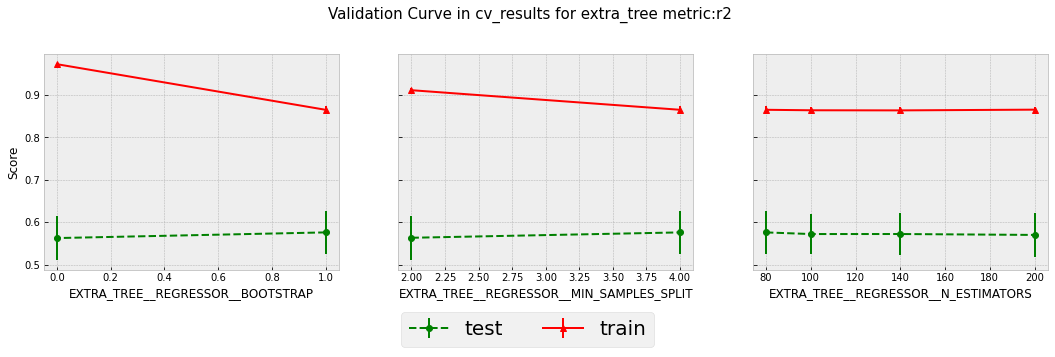

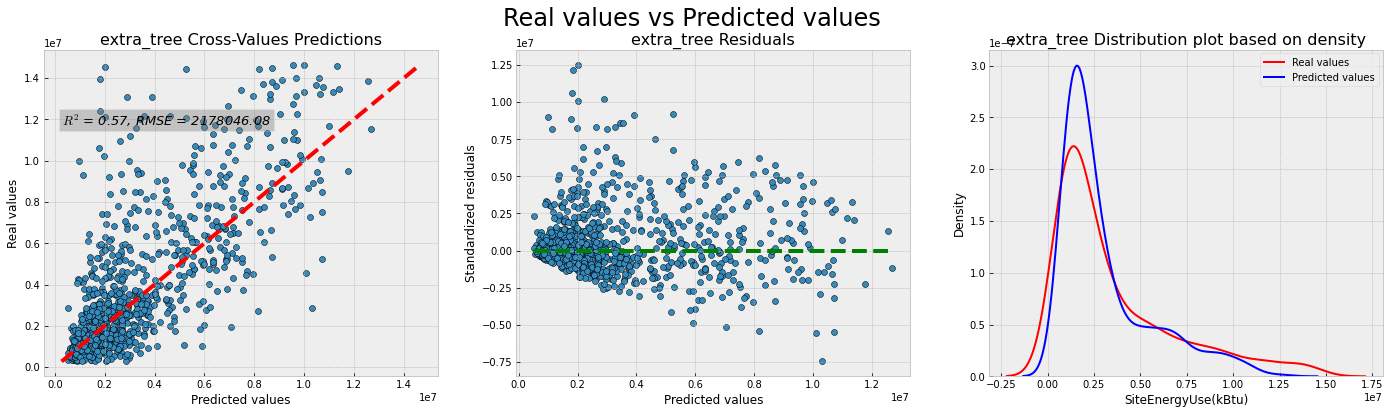

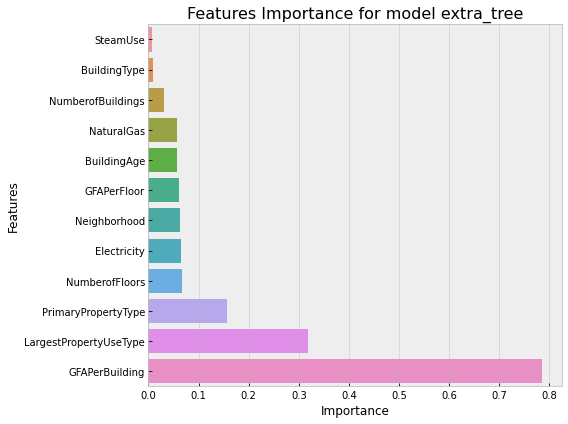

In [101]:
modele_name = 'extra_tree'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

In [102]:
sorted(algo_estimator.grid_searches['gradient_boosting'].get_params().keys())

['cv',
 'error_score',
 'estimator',
 'estimator__gradient_boosting',
 'estimator__gradient_boosting__check_inverse',
 'estimator__gradient_boosting__func',
 'estimator__gradient_boosting__inverse_func',
 'estimator__gradient_boosting__regressor',
 'estimator__gradient_boosting__regressor__alpha',
 'estimator__gradient_boosting__regressor__ccp_alpha',
 'estimator__gradient_boosting__regressor__criterion',
 'estimator__gradient_boosting__regressor__init',
 'estimator__gradient_boosting__regressor__learning_rate',
 'estimator__gradient_boosting__regressor__loss',
 'estimator__gradient_boosting__regressor__max_depth',
 'estimator__gradient_boosting__regressor__max_features',
 'estimator__gradient_boosting__regressor__max_leaf_nodes',
 'estimator__gradient_boosting__regressor__min_impurity_decrease',
 'estimator__gradient_boosting__regressor__min_samples_leaf',
 'estimator__gradient_boosting__regressor__min_samples_split',
 'estimator__gradient_boosting__regressor__min_weight_fraction_leaf

**Boosting** L'idée des méthodes de boosting est de combiner plusieurs modèles faibles pour former un modèle meilleur. Principe du  gradient boosting , Les modèles faibles sont entrainés sur les erreurs résiduelles

estimator  \
8  gradient_boosting   

                                                                                                                                                      best_params  
8  {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 100, 'gradient_boosting__regressor__n_estimators': 1000}

estimator     R2          MAE         RMSE
8  gradient_boosting  0.592  1328329.803  2111314.945

estimator       R2          MAE         RMSE
8  gradient_boosting  0.66977  1142301.909  1781559.676

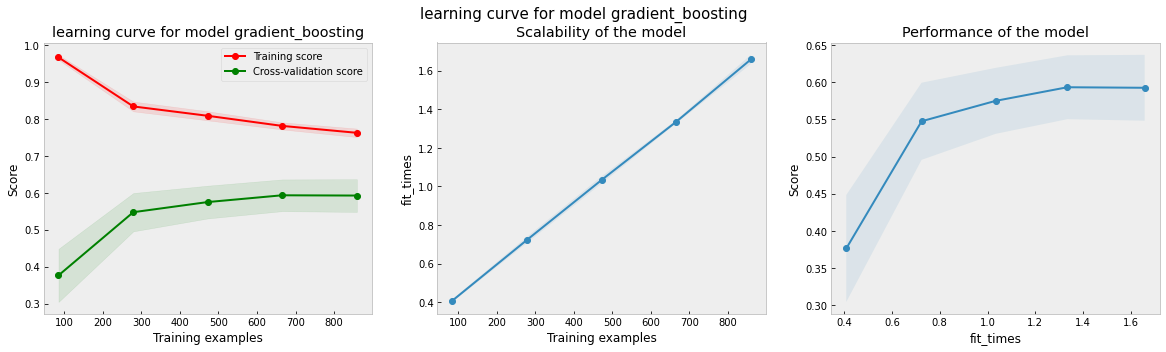

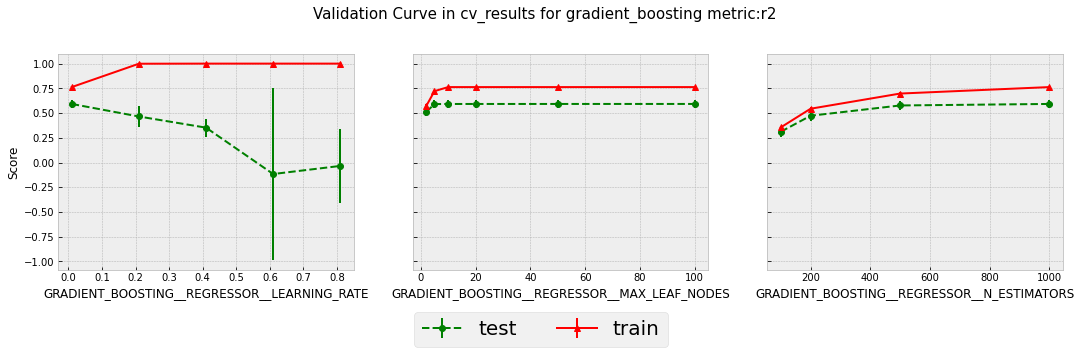

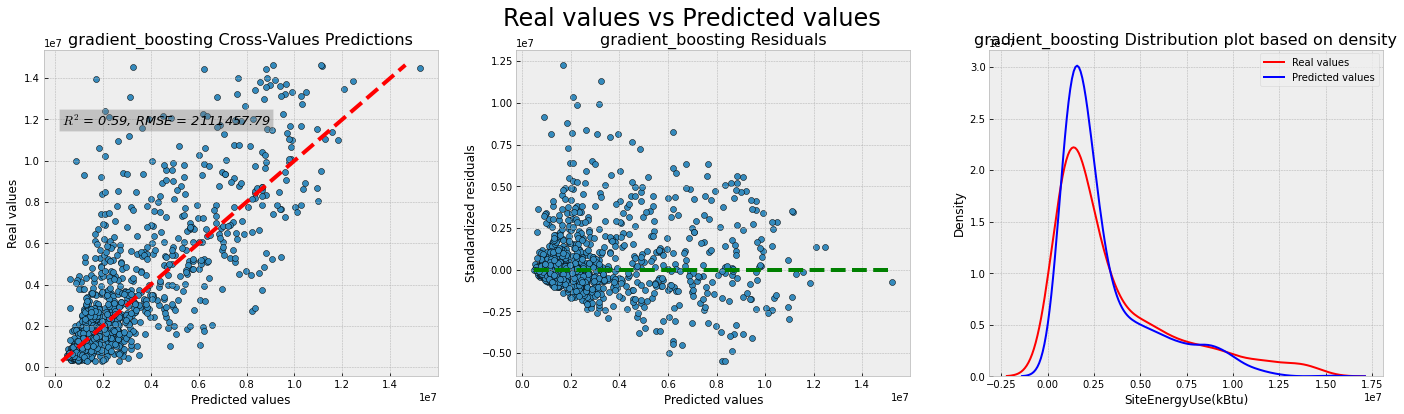

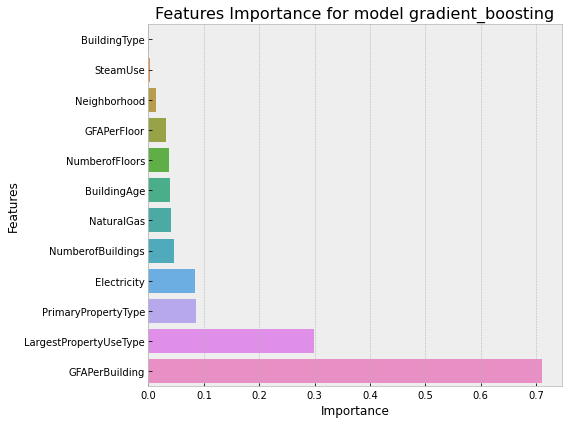

In [103]:
modele_name = 'gradient_boosting'
algo_estimator.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

<a name='en'></a>
# Test avec energystarScore


Nous allons realiser le meme apprentissage , mais cette fois avec l energy starScore, vu que cette variable n est pas bien rempli(70% environs), nous allons implementer un knn inputer sur cette variable, et l integrer dans la pipeline

In [104]:
seattle=pd.read_csv('seattle_cleaned.csv', sep=",") #3376 rows × 46 columns
seattle.shape
seattle = seattle.drop(['Unnamed: 0','DataYear'], axis=1)
#'DataYear', 'Latitude', 'Longitude'
seattle.shape

seattle = seattle.dropna(axis=0)
seattle.shape

(889, 19)

In [105]:
from sklearn.impute import KNNImputer

In [106]:
echantillon = seattle.copy()
echantillon = echantillon.drop(['Latitude','Longitude','GFABuildingRate','GFAParkingRate'], axis=1)


# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor', 'GFABuildingRate', 'GFAParkingRate','ENERGYSTARScore']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity', 'NaturalGas', 'SteamUse', 'GFAPerBuilding', 'GFAPerFloor']
# numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor']
numericColumns = ['NumberofBuildings', 'NumberofFloors',  'BuildingAge','Electricity',   'GFAPerBuilding', 'GFAPerFloor','NaturalGas', 'SteamUse']
qualitativesColumns = list(echantillon.select_dtypes(include=['object']))
#mettre une variable binaire a utiliser pour NaturalGas et SteamUse
booleanColumns = ['NaturalGas', 'SteamUse']
energyStart = ['ENERGYSTARScore']

X = echantillon.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
# Y = echantillon[['SiteEnergyUse(kBtu)']]
Y = echantillon.loc[:,target_variable]

# Y = echantillon[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

def boolean_transformation(X):
    return X.astype(int)


boolean_pipeline = Pipeline([
    ('otherEnergy',FunctionTransformer(boolean_transformation))
                            ])

energy_pipeline = Pipeline([
   ('knn', KNNImputer()), 
  ('rob_scaler', RobustScaler())  
])


# Labelize les variables catégorielles et les ajoute aux variables numériques transformés
categorical_pipeLine = Pipeline([
#     ('OneHotEncoder', OneHotEncoder(handle_unknown = 'ignore') ),
#     ('SVD',TruncatedSVD(n_components=5, n_iter=7, random_state=42))
    
    #meilleurs resultats avec ses parametres
    ('target', TargetEncoder()),    
    # ('std_scaler', StandardScaler()), # Normalisation des données  

     ('rob_scaler', RobustScaler())  
    
])

# Pipeline pour les variables numériques
numerical_pipeline = Pipeline([
    ('rob_scaler', RobustScaler()), # Normalisation des données
#     ('pca', decomposition.PCA())
])


preprocessor = ColumnTransformer([
        ("energy", energy_pipeline, energyStart),
        ("boolean",boolean_pipeline, booleanColumns),
        ("categorical", categorical_pipeLine, qualitativesColumns),    
        ("numeric", numerical_pipeline, numericColumns),                  
    ])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 711 lignes,
Test: 178 lignes.



In [107]:
algo_estimatorDefaultsWithEnergy = EstimatorSelectionByAlgobyDefault(modeldefaults,True)
algo_estimatorDefaultsWithEnergy.fit(X_train,y_train)

Running GridSearchCV for dummy.
model DummyRegressor()
training dummy model done
elapsed time 1.61s
Running GridSearchCV for linear.
model LinearRegression()
training linear model done
elapsed time 0.88s
Running GridSearchCV for elastic_net.
model ElasticNet()
training elastic_net model done
elapsed time 0.93s
Running GridSearchCV for ridge.
model Ridge()
training ridge model done
elapsed time 0.88s
Running GridSearchCV for lasso.
model Lasso()
training lasso model done
elapsed time 0.89s
Running GridSearchCV for svr.
model SVR()
training svr model done
elapsed time 0.97s
Running GridSearchCV for random_forest.
model RandomForestRegressor()
training random_forest model done
elapsed time 1.58s
Running GridSearchCV for extra_tree.
model ExtraTreesRegressor()
training extra_tree model done
elapsed time 1.39s
Running GridSearchCV for gradient_boosting.
model GradientBoostingRegressor()
training gradient_boosting model done
elapsed time 0.57s
All training done.
total time 9.71s


Resultats R2 coefficient de determination

In [108]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_summary(showR2=True)

R2          MAE          RMSE
estimator                                            
dummy                0.141  2449246.929  3.627100e+06
linear             234.778  3780911.553  5.008137e+07
elastic_net          0.012  2272108.432  3.378624e+06
ridge              273.243  3927882.309  5.398889e+07
lasso                0.143  2457552.912  3.630749e+06
svr                  0.182  2451399.791  3.692999e+06
random_forest        0.780   980458.505  1.592544e+06
extra_tree           0.773   978642.229  1.620447e+06
gradient_boosting    0.780   945299.428  1.594417e+06

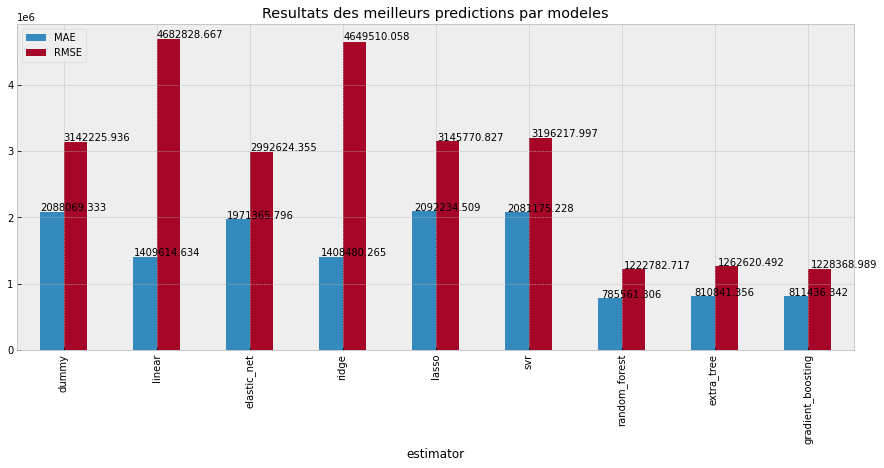

In [109]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graphpredictions()

In [110]:
algo_estimatorWithEnergy = EstimatorSelectionByAlgo(models, params_models,True)
algo_estimatorWithEnergy.fit(X_train,y_train)

Running GridSearchCV for dummy.
training model DummyRegressor()
training dummy model done
elapsed time 0.52s
Running GridSearchCV for linear.
training model LinearRegression()
training linear model done
elapsed time 0.54s
Running GridSearchCV for elastic_net.
training model ElasticNet()
training elastic_net model done
elapsed time 8.62s
Running GridSearchCV for ridge.
training model Ridge(alpha=100000.0, fit_intercept=False)
training ridge model done
elapsed time 18.29s
Running GridSearchCV for lasso.
training model Lasso(alpha=100000.0, fit_intercept=False)
training lasso model done
elapsed time 17.92s
Running GridSearchCV for svr.
training model SVR()
training svr model done
elapsed time 13.05s
Running GridSearchCV for random_forest.
training model RandomForestRegressor()
training random_forest model done
elapsed time 3.44s
Running GridSearchCV for extra_tree.
training model ExtraTreesRegressor()
training extra_tree model done
elapsed time 2.76s
Running GridSearchCV for gradient_boos

In [111]:
algo_estimatorWithEnergy.getBestModeleScore_summary(True,showR2=True).compare(algo_estimatorDefaultsWithEnergy.getBestModeleScore_summary(showR2=True), align_axis=0).rename(index={'other': 'default parameter', 'self': 'custom parameter '})

R2          MAE          RMSE
estimator                                                              
elastic_net       custom parameter     0.239  1859064.603  2.964324e+06
                  default parameter    0.012  2272108.432  3.378624e+06
ridge             custom parameter     1.030  3426111.782  4.839100e+06
                  default parameter  273.243  3927882.309  5.398889e+07
lasso             custom parameter     1.045  3467334.000  4.856013e+06
                  default parameter    0.143  2457552.912  3.630749e+06
svr               custom parameter     0.778   968743.851  1.600074e+06
                  default parameter    0.182  2451399.791  3.692999e+06
random_forest     custom parameter     0.782   970487.024  1.582493e+06
                  default parameter    0.780   980458.505  1.592544e+06
extra_tree        custom parameter     0.781   949060.005  1.588916e+06
                  default parameter    0.773   978642.229  1.620447e+06
gradient_boosting custom parameter     0.786   946110.412  1.572389e+06
                  default parameter    0.780   945299.428  1.594417e+06

Clairement les modeles random_forest, extra_tree, et gradient boosting ont les meilleurs coefficient de determination , nous allons nous attarder sur ces 3 meilleurs modeles

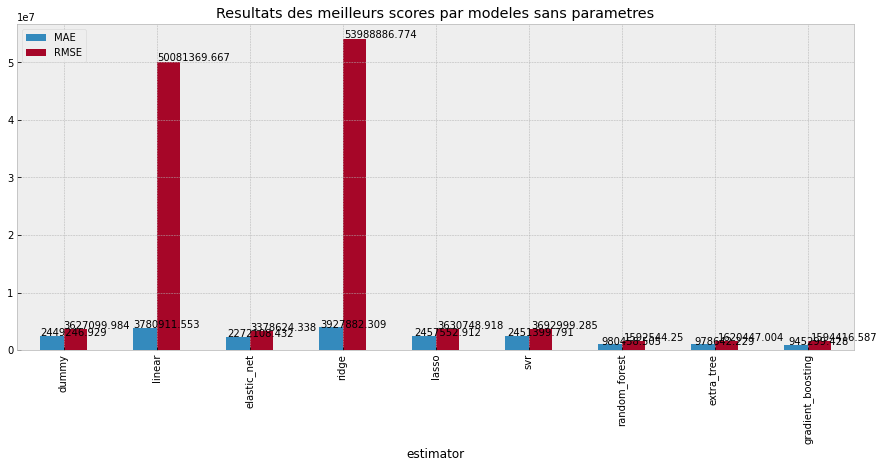

In [112]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graph()

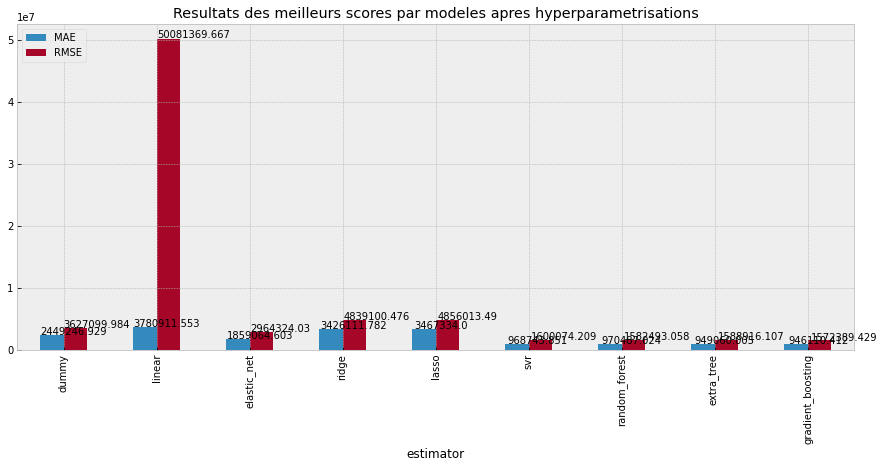

In [113]:
algo_estimatorWithEnergy.getBestModeleScore_graph()

Globalement nos resultats sont toujours meilleurs avec nos hyperparametres

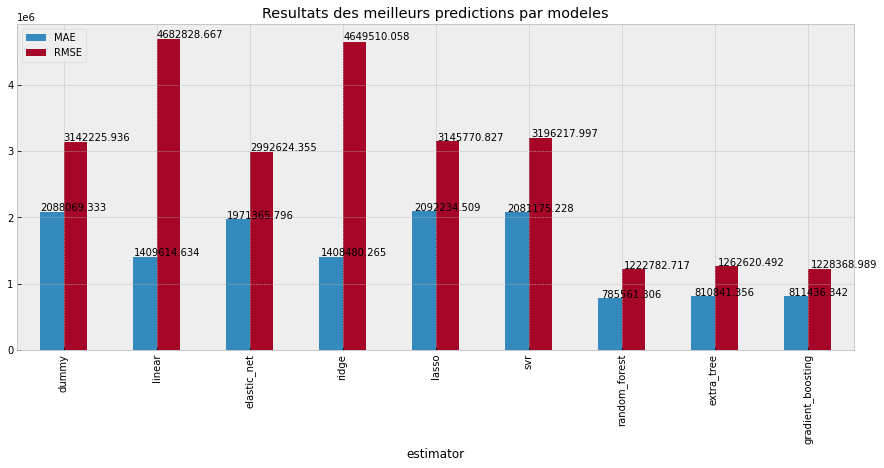

In [114]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_graphpredictions()

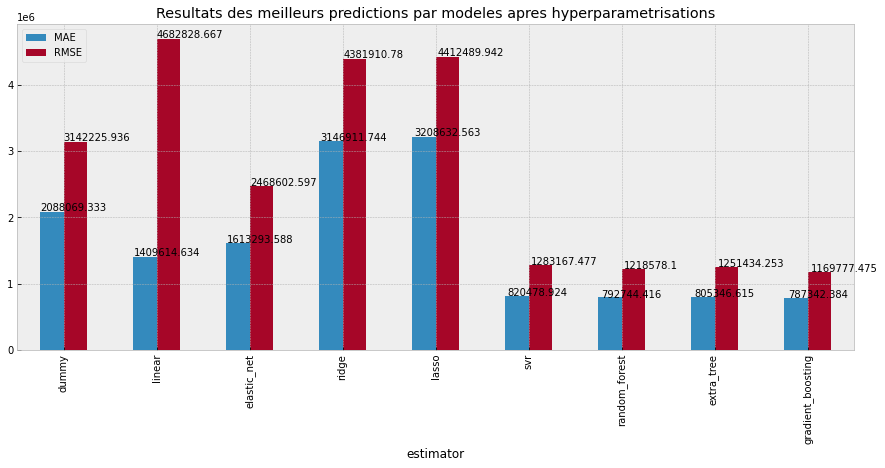

In [115]:
algo_estimatorWithEnergy.getBestModeleScore_graphpredictions()

In [116]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True)

R2          MAE         RMSE
estimator                                           
dummy             -0.08305  2088069.333  3142225.936
linear            -1.40542  1409614.634  4682828.667
elastic_net        0.01762  1971365.796  2992624.355
ridge             -1.37131  1408480.265  4649510.058
lasso             -0.08550  2092234.509  3145770.827
svr               -0.12059  2081175.228  3196217.997
random_forest      0.83599   785561.306  1222782.717
extra_tree         0.82513   810841.356  1262620.492
gradient_boosting  0.83449   811436.342  1228368.989

<a name='sc'></a>
# Comparaisons des resultats 

**Compare les modeles avec EnergyStarScore avec hypeparametre et sans :**

In [117]:
algo_estimatorWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True), align_axis=0).rename(index={'other': 'no option', 'self': 'with options '})

R2          MAE         RMSE
estimator                                                         
elastic_net       with options   0.33154  1613293.588  2468602.597
                  no option      0.01762  1971365.796  2992624.355
ridge             with options  -1.10621  3146911.744  4381910.780
                  no option     -1.37131  1408480.265  4649510.058
lasso             with options  -1.13571  3208632.563  4412489.942
                  no option     -0.08550  2092234.509  3145770.827
svr               with options   0.81939   820478.924  1283167.477
                  no option     -0.12059  2081175.228  3196217.997
random_forest     with options   0.83712   792744.416  1218578.100
                  no option      0.83599   785561.306  1222782.717
extra_tree        with options   0.82821   805346.615  1251434.253
                  no option      0.82513   810841.356  1262620.492
gradient_boosting with options   0.84990   787342.384  1169777.475
                  no option      0.83449   811436.342  1228368.989

**Compare les modeles avec EnergyStarScore sans hypeparametres avec les modeles sans  EnergyStarScore sans hypeparametre:**

In [118]:
algo_estimatorDefaultsWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(withoutparam , align_axis=0).rename(index={'other': 'without energy', 'self': ' with energy'}) 

R2          MAE          RMSE
estimator                                                            
dummy              with energy    -0.08305  2088069.333  3.142226e+06
                  without energy  -0.10038  2158287.124  3.252122e+06
linear             with energy    -1.40542  1409614.634  4.682829e+06
                  without energy -46.34157  3053103.836  2.133123e+07
elastic_net        with energy     0.01762  1971365.796  2.992624e+06
                  without energy   0.03824  2023410.879  3.040383e+06
ridge              with energy    -1.37131  1408480.265  4.649510e+06
                  without energy -53.43271  3147662.222  2.287308e+07
lasso              with energy    -0.08550  2092234.509  3.145771e+06
                  without energy  -0.10108  2159543.571  3.253143e+06
svr                with energy    -0.12059  2081175.228  3.196218e+06
                  without energy  -0.13525  2149638.769  3.303240e+06
random_forest      with energy     0.83599   785561.306  1.222783e+06
                  without energy   0.65644  1173501.448  1.817162e+06
extra_tree         with energy     0.82513   810841.356  1.262620e+06
                  without energy   0.65128  1201450.602  1.830775e+06
gradient_boosting  with energy     0.83449   811436.342  1.228369e+06
                  without energy   0.66803  1151245.250  1.786256e+06

**Compare les modeles avec EnergyStarScore avec hypeparametres avec les modeles sans  EnergyStarScore avec hypeparametre:**

In [119]:
algo_estimatorWithEnergy.getBestModeleScore_scorePrediction(True,True).compare(withParam, align_axis=0).rename(index={'other': 'options and no energy', 'self': 'options with energy'})

R2          MAE          RMSE
estimator                                                                   
dummy             options with energy    -0.08305  2088069.333  3.142226e+06
                  options and no energy  -0.10038  2158287.124  3.252122e+06
linear            options with energy    -1.40542  1409614.634  4.682829e+06
                  options and no energy -46.34157  3053103.836  2.133123e+07
elastic_net       options with energy     0.33154  1613293.588  2.468603e+06
                  options and no energy  -0.41428  1786815.168  3.686906e+06
ridge             options with energy    -1.10621  3146911.744  4.381911e+06
                  options and no energy  -0.87808  1830047.140  4.248659e+06
lasso             options with energy    -1.13571  3208632.563  4.412490e+06
                  options and no energy  -1.21317  1851654.659  4.612137e+06
svr               options with energy     0.81939   820478.924  1.283167e+06
                  options and no energy   0.62650  1239677.193  1.894686e+06
random_forest     options with energy     0.83712   792744.416  1.218578e+06
                  options and no energy   0.67616  1154977.467  1.764236e+06
extra_tree        options with energy     0.82821   805346.615  1.251434e+06
                  options and no energy   0.67860  1143173.744  1.757592e+06
gradient_boosting options with energy     0.84990   787342.384  1.169777e+06
                  options and no energy   0.66977  1142301.909  1.781560e+06

<a name='sl'></a>
# Selection des trois meilleurs algorithme

Jetons un coup d oeil sur les trois modeles les plus performants , a savoir <code>random forest, extra tree et gradient boosting</code>

estimator  \
6  random_forest   

                                                                                         best_params  
6  {'random_forest__regressor__max_features': 'auto', 'random_forest__regressor__n_estimators': 100}

estimator     R2         MAE         RMSE
6  random_forest  0.782  970487.024  1582493.058

estimator       R2         MAE       RMSE
6  random_forest  0.83712  792744.416  1218578.1

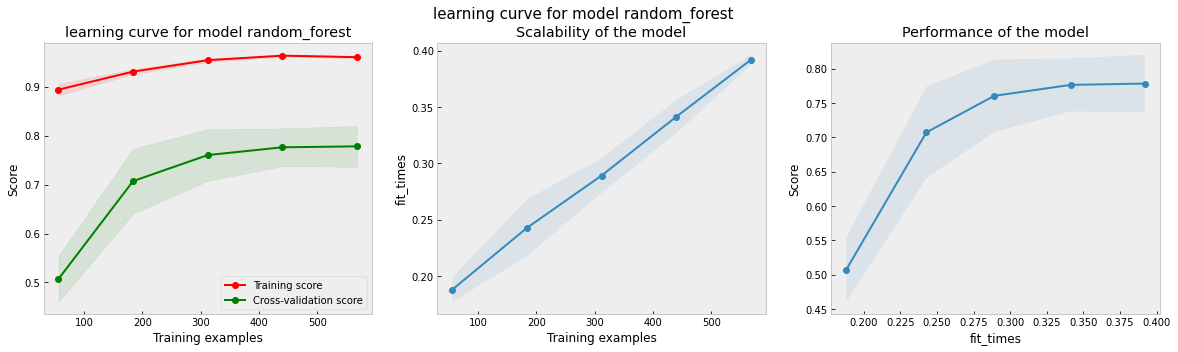

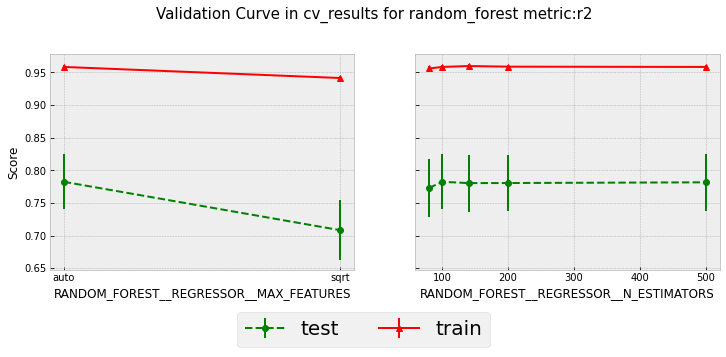

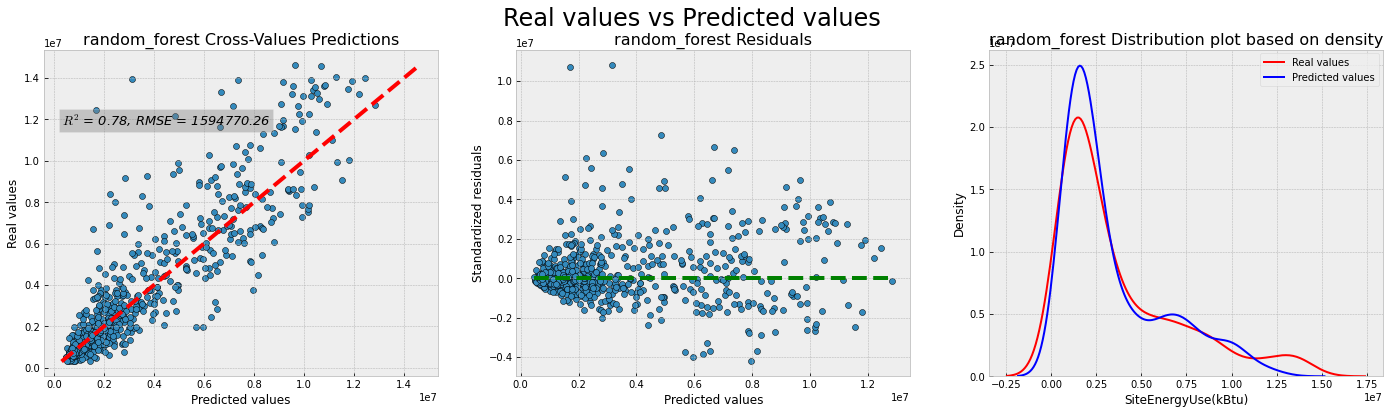

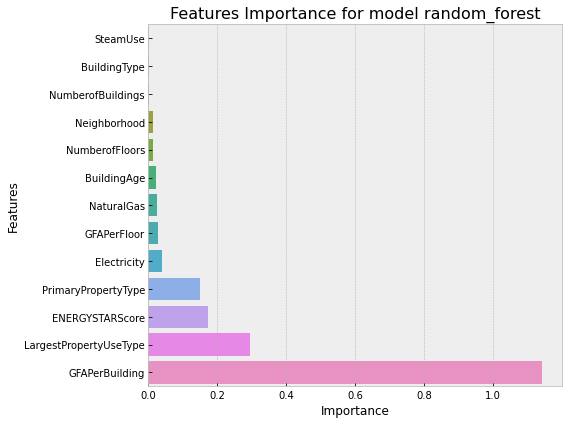

In [120]:
modele_name = 'random_forest'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

estimator  \
7  extra_tree   

                                                                                                                             best_params  
7  {'extra_tree__regressor__bootstrap': False, 'extra_tree__regressor__min_samples_split': 4, 'extra_tree__regressor__n_estimators': 80}

estimator     R2         MAE         RMSE
7  extra_tree  0.781  949060.005  1588916.107

estimator       R2         MAE         RMSE
7  extra_tree  0.82821  805346.615  1251434.253

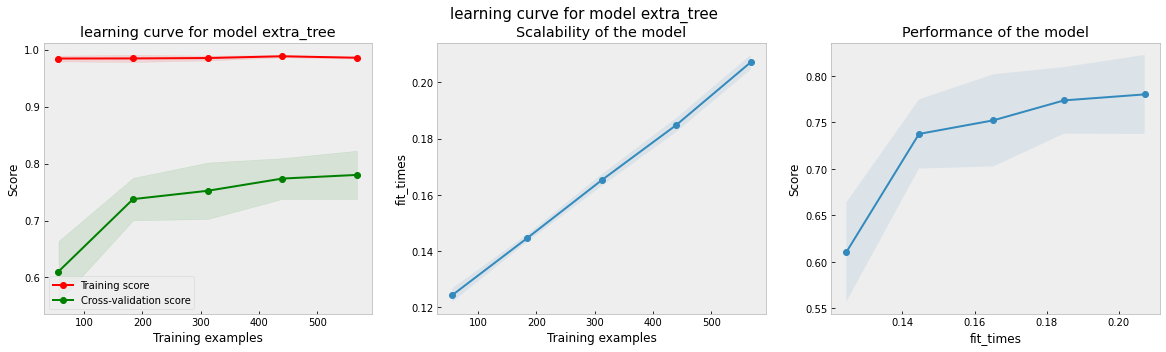

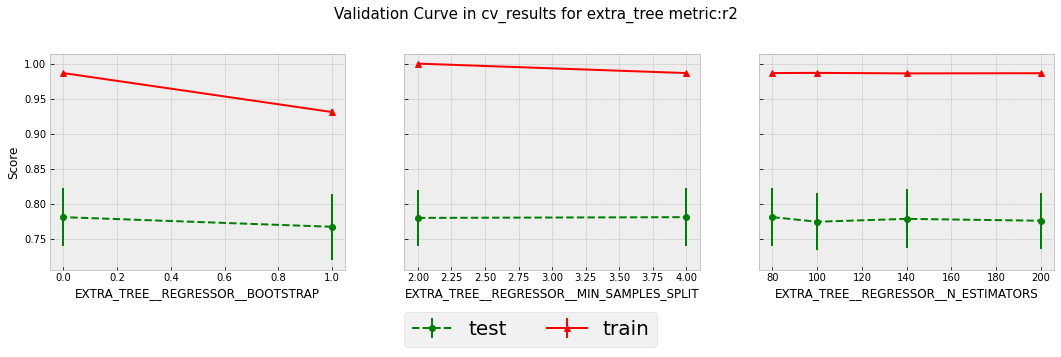

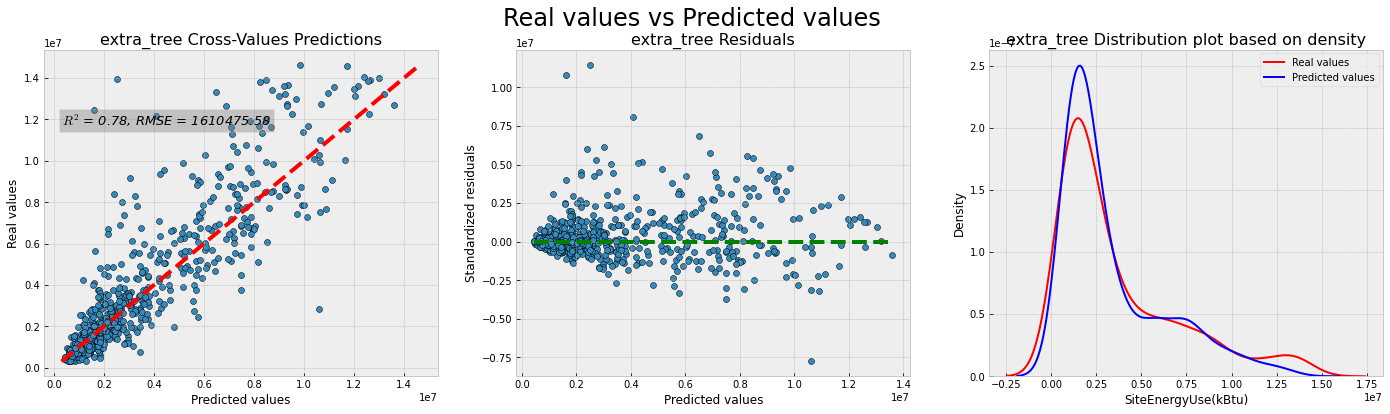

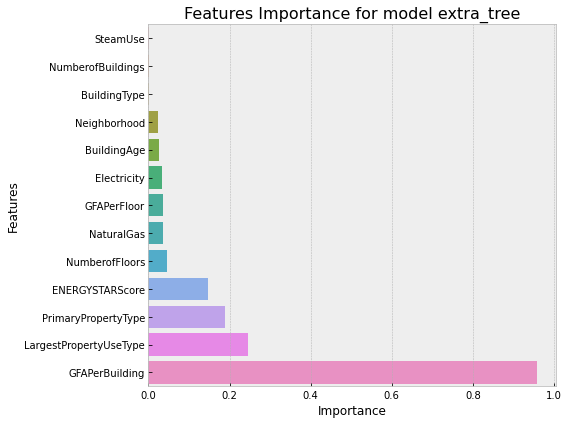

In [121]:
modele_name = 'extra_tree'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

estimator  \
8  gradient_boosting   

                                                                                                                                                      best_params  
8  {'gradient_boosting__regressor__learning_rate': 0.01, 'gradient_boosting__regressor__max_leaf_nodes': 100, 'gradient_boosting__regressor__n_estimators': 1000}

estimator     R2         MAE         RMSE
8  gradient_boosting  0.786  946110.412  1572389.429

estimator      R2         MAE         RMSE
8  gradient_boosting  0.8499  787342.384  1169777.475

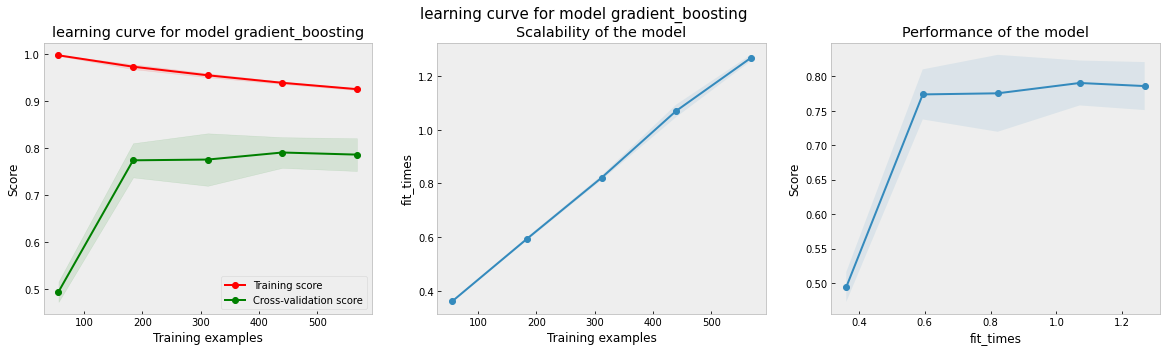

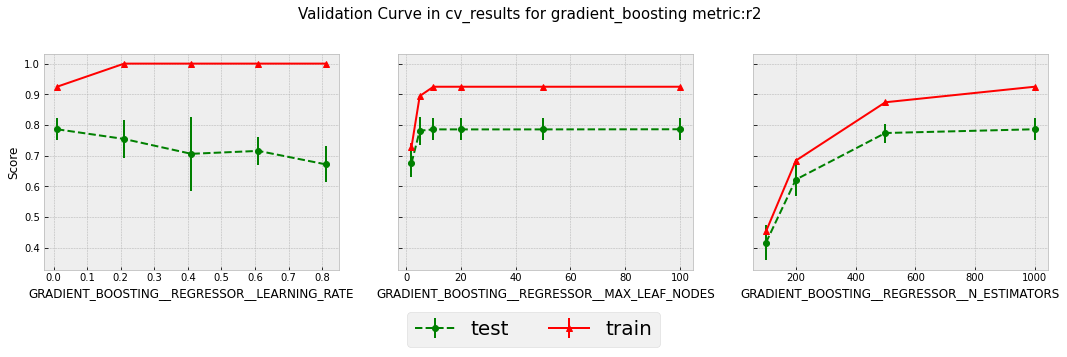

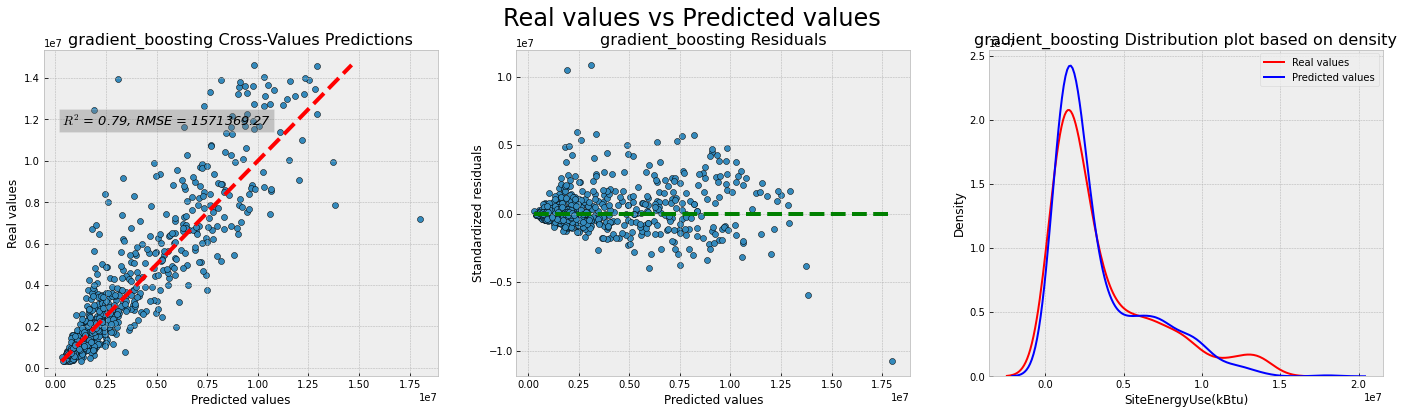

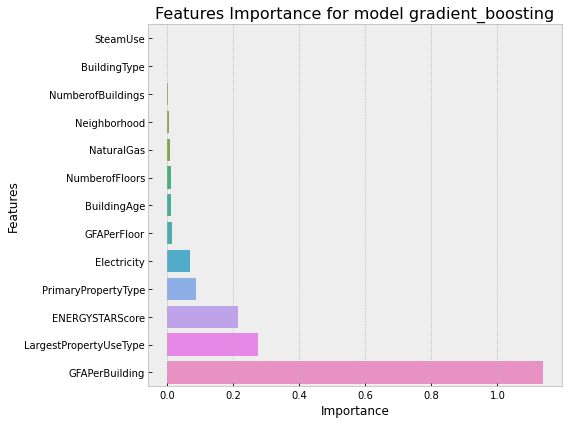

In [122]:
modele_name = 'gradient_boosting'
algo_estimatorWithEnergy.getAllResultsByModelName(modele_name,showLearningCure=True,showValidationCurve=True,showLasso=False,showFeaturesImportances=True)

On peut remarquer que l ajout de la colonne energy star score a grandement influer sur les performances de nos modeles



Les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score.

En revanche, cette variable est encore peu renseignée et le jeu de données comporte peu d'entrées. Il est donc difficile de savoir si cette amélioration est rééllement significative. Il faut également prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.